## Importing dependancies 

In [1]:
import numpy as np
import pandas as pd

from keras.layers import Dense, Input, Flatten, BatchNormalization
from keras.models import Model, load_model
import keras.backend as K
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
import os



Using TensorFlow backend.


### Necessary Functions

In [2]:
def training_eigen_1(dataframe_train, time_step, matrix_width, sample_size):
  X_train = []
  Y_train = []
  max_time = max(dataframe_train['Start'])
  
   #df_new is adjusted for time bounds
  df_new = dataframe_train.loc[dataframe_train['Start'] <= (max_time - time_step * (matrix_width + 1))]
  
  
  nodes = int(max(max(dataframe_train['Source'].unique()), max(dataframe_train['Target'].unique())))
  
  #??
  index_list = np.rint(np.random.uniform(low=0, high=(len(df_new) - 1), size = sample_size))
  
  for i in tqdm(index_list):
    
    time = df_new['Start'].iloc[int(i)]
    x_batch = []
    y_batch = []
    
    
    for j in range(matrix_width + 1):
      tr = (time + j * time_step, time + (j + 1) * time_step)
      eigen_vector = eigen_centrality(get_adj_time_range(tr, dataframe=dataframe_train, nodes=nodes))
      first_order_vector = list(create_vector(timerange=tr, dataframe=dataframe_train, nodes=nodes))
      
      
      for vec in eigen_vector:
        first_order_vector.append(vec)
      
      
      if j == (matrix_width):
        y_batch.append(first_order_vector)
        
      else:
        x_batch.append(first_order_vector)
        
    
    X_train.append(x_batch)
    Y_train.append(y_batch)
    
  return np.asarray(X_train), np.asarray(Y_train)



#function orginially from infectious for adjacency matrix
def get_adj_time_range(timerange, dataframe, nodes):
  
  df_copy = deepcopy(dataframe)
  
  #take slice of dataframe based on time
  dataframe_slice = df_copy.loc[(dataframe['Start'] >= timerange[0]) & (df_copy['Start'] <= timerange[1])]
  
  x = np.zeros((nodes, nodes))
  
  #fill adj. matrix
  for i, j in zip(dataframe_slice['Source'], dataframe_slice['Target']):
    x[int(i - 1)][int(j - 1)] += 1
    x[int(j -1)][int(i - 1)] += 1
    
  return x



def eigen_centrality(adjacency_matrix):
  
  '''
  Function that takes an adjacency matrix and returns the eigen vector centrality
  for said matrix
  '''
  eigen_all = np.linalg.eig(adjacency_matrix)
  
  index = np.argmax(eigen_all[0])
  eigen_vector = np.real(eigen_all[1][index])
  
  normalized = eigen_vector / np.linalg.norm(eigen_vector)
  
  return normalized



def create_vector(timerange, dataframe, nodes):
  
  y = deepcopy(dataframe)

  data_create_vector = y.loc[(y['Start'] >= timerange[0]) & (y['Start'] <= timerange[1])]
  

  x = np.zeros((int((nodes ** 2 - nodes)/2), ))
  
  for i in range(len(data_create_vector)):
    set = (data_create_vector['Source'].iloc[i], data_create_vector['Target'].iloc[i])
    reset = (min(set) - 1, max(set) - 1)
    index = nodes * (reset[0]) - reset[0]*(1 + reset[0])/2 + (reset[1] - reset[0] - 1)
    x[int(index)] += 1
    
    
  return x



#puts vectors in training set and validation set
def training_data(dataframe_train, time_step, matrix_width, sample_size):
  X_train = []
  Y_train = []
  max_time = max(dataframe_train['Start'])
  #df_new is adjusted for time bounds
  df_new = dataframe_train.loc[dataframe_train['Start'] <= (max_time - time_step * (matrix_width + 1))]
  
  
  nodes = max(max(dataframe_train['Source'].unique()), max(dataframe_train['Target'].unique()))
 
  index_list = np.rint(np.random.uniform(low=0, high=(len(df_new) - 1), size=sample_size))
  
  for i in tqdm(index_list):
    
    time = df_new['Start'].iloc[int(i)]
    x_batch = []
    for j in range(matrix_width + 1):
      if j == (matrix_width):
#         print('for every y we have dataframe of length')
#         print(len(dataframe_train))
        y_batch = create_vector((time + j * time_step, time + (j + 1) * time_step), dataframe_train, nodes)
      else:
#         print('Length of "dataframe_train": {}'.format(len(dataframe_train)))
        x_batch.append(create_vector((time + j * time_step, time + (j + 1) * time_step), dataframe_train, nodes))
        
    
    X_train.append(x_batch)
    Y_train.append(y_batch)
    
  return np.asarray(X_train), np.asarray(Y_train)


def training_eigen_2(dataframe_train, time_step, matrix_width, sample_size):
  X_train = []
  Y_train = []
  max_time = max(dataframe_train['Start'])
  #df_new is adjusted for time bounds
  df_new = dataframe_train.loc[dataframe_train['Start'] <= (max_time - time_step * (matrix_width + 1))]
  
  
  nodes = max(max(dataframe_train['Source'].unique()), max(dataframe_train['Target'].unique()))
 
  index_list = np.rint(np.random.uniform(low=0, high=(len(df_new) - 1), size=sample_size))
  
  for i in tqdm(index_list):
    
    time = df_new['Start'].iloc[int(i)]
    x_batch = []
    for j in range(matrix_width + 1):
      
      # Create the adjacency matrix
      adj_matrix = get_adj_time_range(dataframe=dataframe_train,timerange=(time + j * time_step, time + (j + 1) * time_step), nodes=nodes )
      eigen_vector_centrality = eigen_centrality(adj_matrix)
      engineered_eigen_vector = []
      
      # Create the engineered eigenvector
      for m in range(nodes):
        for n in range(m+1, nodes):
          engineered_eigen_vector.append(eigen_vector_centrality[m] * eigen_vector_centrality[n])
      
      eigen_vector_np = np.asarray(engineered_eigen_vector)
      
      
      
      if j == (matrix_width):
#         print('for every y we have dataframe of length')
#         print(len(dataframe_train))
        
        y_batch = create_vector((time + j * time_step, time + (j + 1) * time_step), dataframe_train, nodes) * eigen_vector_np
      else:
#         print('Length of "dataframe_train": {}'.format(len(dataframe_train)))
        x_batch.append(create_vector((time + j * time_step, time + (j + 1) * time_step), dataframe_train, nodes) * eigen_vector_np)
        
    
    X_train.append(x_batch)
    Y_train.append(y_batch)
    
  return np.asarray(X_train), np.asarray(Y_train)

## Loading in past data

In [3]:
X_train = np.load(os.path.join(os.getcwd(), 'X_training_06_14.npy'))
y_train = np.load(os.path.join(os.getcwd(), 'y_training_06_14.npy'))

In [4]:
df_init = pd.read_csv('reality.csv')
df = df_init.drop('End', axis=1)
nodes = max(max(df['Source'].unique()), max(df['Target'].unique()))
df.head()

matrix_width = 5
vector_length = int((nodes ** 2 - nodes)/2)
time_step = 800

### Making the validation data

In [7]:
def create_vector(timerange, dataframe, nodes):
  
    x = deepcopy(dataframe)
  #   print('Max of x: {}'.format(max(x['Start'])))
  #   print('TimeRange: {}'.format(timerange))
    data_create_vector = x.loc[(x['Start'] >= timerange[0]) & (x['Start'] <= timerange[1])]

  #   print('Max of time "data_create_vector": {}'.format(max(data_create_vector['Start'])))
  #   print('Length of "data_create_vector": {}'.format(len(data_create_vector)))
    x = np.zeros( ( int((nodes ** 2 - nodes)/2, )) )

    for i in range(len(data_create_vector)):
        set = (data_create_vector['Source'].iloc[i], data_create_vector['Target'].iloc[i])
        reset = (min(set) - 1, max(set) - 1)
        index = nodes * (reset[0]) - reset[0]*(1 + reset[0])/2 + (reset[1] - reset[0] - 1)
        x[int(index)] += 1
    return x

In [10]:
def training_data(dataframe_train, time_step, matrix_width, sample_size):
    X_train = []
    Y_train = []
    max_time = max(dataframe_train['Start'])
    #df_new is adjusted for time bounds
    df_new = dataframe_train.loc[dataframe_train['Start'] <= (max_time - time_step * (matrix_width + 1))]


    nodes = max(max(dataframe_train['Source'].unique()), max(dataframe_train['Target'].unique()))

    index_list = np.rint(np.random.uniform(low=0, high=(len(df_new) - 1), size=sample_size))

    for i in tqdm(index_list):

        time = df_new['Start'].iloc[int(i)]
        x_batch = []
        for j in range(matrix_width + 1):
            if j == (matrix_width):
      #         print('for every y we have dataframe of length')
      #         print(len(dataframe_train))
                y_batch = create_vector((time + j * time_step, time + (j + 1) * time_step), dataframe_train, nodes)
            else:
      #         print('Length of "dataframe_train": {}'.format(len(dataframe_train)))
                x_batch.append(create_vector((time + j * time_step, time + (j + 1) * time_step), dataframe_train, nodes))


        X_train.append(x_batch)
        Y_train.append(y_batch)

    return np.asarray(X_train), np.asarray(Y_train)



x_validate,y_validate = training_data(df, time_step, matrix_width, 1500)

100%|██████████| 1500/1500 [04:55<00:00,  5.08it/s]


## Creating the Model (with batch norm) 

In [6]:
x_validate,y_validate = training_data(df, time_step, matrix_width, 1500)

input_vector = Input(shape=(matrix_width, vector_length))
flatten = Flatten()(input_vector)
encoded = Dense(128, activation='relu', name='encoded_1')(flatten)
norm = BatchNormalization()(encoded)
encoded = Dense(64, activation='relu', name='encoded_2')(norm)
norm = BatchNormalization()(encoded)

decoded = Dense(128, activation='relu', name='decoded_1')(norm)
norm = BatchNormalization()(decoded)
decoded = Dense(vector_length, name='decoded_2')(norm)

model = Model(input_vector, decoded)

100%|██████████| 1500/1500 [05:06<00:00,  4.89it/s]


In [7]:
model.compile(optimizer='adadelta', loss='mse')
history = model.fit(X_train, y_train, batch_size=128, epochs=50,validation_data=(x_validate,y_validate),shuffle=True)

Train on 50000 samples, validate on 1500 samples
Epoch 1/50


42880/50000 [========================>.....] - ETA: 7:58 - loss: 0.586 - ETA: 4:23 - loss: 0.549 - ETA: 3:11 - loss: 0.559 - ETA: 2:35 - loss: 0.556 - ETA: 2:13 - loss: 0.559 - ETA: 1:57 - loss: 0.569 - ETA: 1:47 - loss: 0.565 - ETA: 1:39 - loss: 0.565 - ETA: 1:33 - loss: 0.558 - ETA: 1:28 - loss: 0.562 - ETA: 1:24 - loss: 0.556 - ETA: 1:20 - loss: 0.561 - ETA: 1:17 - loss: 0.560 - ETA: 1:15 - loss: 0.554 - ETA: 1:13 - loss: 0.552 - ETA: 1:11 - loss: 0.552 - ETA: 1:09 - loss: 0.552 - ETA: 1:07 - loss: 0.555 - ETA: 1:06 - loss: 0.554 - ETA: 1:05 - loss: 0.553 - ETA: 1:03 - loss: 0.552 - ETA: 1:02 - loss: 0.552 - ETA: 1:02 - loss: 0.551 - ETA: 1:01 - loss: 0.549 - ETA: 1:00 - loss: 0.549 - ETA: 59s - loss: 0.548 - ETA: 58s - loss: 0.55 - ETA: 58s - loss: 0.54 - ETA: 57s - loss: 0.54 - ETA: 57s - loss: 0.54 - ETA: 56s - loss: 0.54 - ETA: 56s - loss: 0.54 - ETA: 55s - loss: 0.54 - ETA: 55s - loss: 0.54 - ETA: 54s - loss: 0.54 - ETA: 54s - loss: 0.53 - ETA: 53s - loss: 0.53 - ETA: 53s - los

43520/50000 [=========================>....] - ETA: 46s - loss: 0.37 - ETA: 47s - loss: 0.38 - ETA: 47s - loss: 0.39 - ETA: 47s - loss: 0.37 - ETA: 47s - loss: 0.38 - ETA: 47s - loss: 0.38 - ETA: 46s - loss: 0.38 - ETA: 47s - loss: 0.38 - ETA: 47s - loss: 0.38 - ETA: 47s - loss: 0.38 - ETA: 47s - loss: 0.38 - ETA: 47s - loss: 0.38 - ETA: 47s - loss: 0.37 - ETA: 47s - loss: 0.37 - ETA: 47s - loss: 0.38 - ETA: 47s - loss: 0.37 - ETA: 47s - loss: 0.37 - ETA: 46s - loss: 0.37 - ETA: 46s - loss: 0.37 - ETA: 46s - loss: 0.37 - ETA: 46s - loss: 0.37 - ETA: 46s - loss: 0.37 - ETA: 47s - loss: 0.37 - ETA: 47s - loss: 0.37 - ETA: 47s - loss: 0.37 - ETA: 47s - loss: 0.37 - ETA: 47s - loss: 0.37 - ETA: 48s - loss: 0.37 - ETA: 48s - loss: 0.37 - ETA: 48s - loss: 0.37 - ETA: 48s - loss: 0.37 - ETA: 48s - loss: 0.37 - ETA: 48s - loss: 0.37 - ETA: 48s - loss: 0.37 - ETA: 48s - loss: 0.37 - ETA: 48s - loss: 0.37 - ETA: 48s - loss: 0.37 - ETA: 48s - loss: 0.37 - ETA: 48s - loss: 0.37 - ETA: 48s - loss: 

50000/50000 [==============================] - ETA: 6s - loss: 0.359 - ETA: 6s - loss: 0.359 - ETA: 5s - loss: 0.359 - ETA: 5s - loss: 0.359 - ETA: 5s - loss: 0.359 - ETA: 5s - loss: 0.359 - ETA: 5s - loss: 0.359 - ETA: 5s - loss: 0.359 - ETA: 5s - loss: 0.358 - ETA: 5s - loss: 0.358 - ETA: 4s - loss: 0.358 - ETA: 4s - loss: 0.358 - ETA: 4s - loss: 0.358 - ETA: 4s - loss: 0.358 - ETA: 4s - loss: 0.358 - ETA: 4s - loss: 0.358 - ETA: 4s - loss: 0.358 - ETA: 4s - loss: 0.358 - ETA: 3s - loss: 0.358 - ETA: 3s - loss: 0.358 - ETA: 3s - loss: 0.358 - ETA: 3s - loss: 0.358 - ETA: 3s - loss: 0.358 - ETA: 3s - loss: 0.358 - ETA: 3s - loss: 0.358 - ETA: 3s - loss: 0.358 - ETA: 2s - loss: 0.358 - ETA: 2s - loss: 0.358 - ETA: 2s - loss: 0.357 - ETA: 2s - loss: 0.357 - ETA: 2s - loss: 0.357 - ETA: 2s - loss: 0.357 - ETA: 2s - loss: 0.357 - ETA: 2s - loss: 0.357 - ETA: 1s - loss: 0.357 - ETA: 1s - loss: 0.357 - ETA: 1s - loss: 0.357 - ETA: 1s - loss: 0.357 - ETA: 1s - loss: 0.357 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 45s - loss: 0.30 - ETA: 44s - loss: 0.31 - ETA: 44s - loss: 0.31 - ETA: 45s - loss: 0.31 - ETA: 45s - loss: 0.31 - ETA: 45s - loss: 0.31 - ETA: 44s - loss: 0.31 - ETA: 44s - loss: 0.31 - ETA: 44s - loss: 0.32 - ETA: 43s - loss: 0.32 - ETA: 43s - loss: 0.32 - ETA: 43s - loss: 0.32 - ETA: 43s - loss: 0.32 - ETA: 42s - loss: 0.32 - ETA: 42s - loss: 0.32 - ETA: 42s - loss: 0.32 - ETA: 42s - loss: 0.32 - ETA: 42s - loss: 0.32 - ETA: 42s - loss: 0.32 - ETA: 41s - loss: 0.32 - ETA: 41s - loss: 0.32 - ETA: 41s - loss: 0.32 - ETA: 41s - loss: 0.32 - ETA: 41s - loss: 0.33 - ETA: 41s - loss: 0.33 - ETA: 41s - loss: 0.33 - ETA: 40s - loss: 0.33 - ETA: 40s - loss: 0.33 - ETA: 40s - loss: 0.33 - ETA: 40s - loss: 0.33 - ETA: 40s - loss: 0.33 - ETA: 40s - loss: 0.33 - ETA: 40s - loss: 0.33 - ETA: 39s - loss: 0.33 - ETA: 39s - loss: 0.33 - ETA: 39s - loss: 0.33 - ETA: 39s - loss: 0.33 - ETA: 39s - loss: 0.33 - ETA: 39s - loss: 0.33 - ETA: 39s - loss: 

43520/50000 [=========================>....] - ETA: 46s - loss: 0.29 - ETA: 45s - loss: 0.30 - ETA: 44s - loss: 0.32 - ETA: 43s - loss: 0.32 - ETA: 44s - loss: 0.31 - ETA: 43s - loss: 0.31 - ETA: 43s - loss: 0.31 - ETA: 43s - loss: 0.31 - ETA: 43s - loss: 0.31 - ETA: 43s - loss: 0.31 - ETA: 43s - loss: 0.31 - ETA: 43s - loss: 0.31 - ETA: 42s - loss: 0.31 - ETA: 42s - loss: 0.31 - ETA: 42s - loss: 0.31 - ETA: 42s - loss: 0.31 - ETA: 42s - loss: 0.30 - ETA: 42s - loss: 0.30 - ETA: 42s - loss: 0.30 - ETA: 42s - loss: 0.30 - ETA: 42s - loss: 0.30 - ETA: 42s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 40s - loss: 0.30 - ETA: 40s - loss: 0.30 - ETA: 40s - loss: 0.30 - ETA: 40s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.298 - ETA: 5s - loss: 0.298 - ETA: 5s - loss: 0.298 - ETA: 5s - loss: 0.298 - ETA: 5s - loss: 0.298 - ETA: 5s - loss: 0.298 - ETA: 5s - loss: 0.298 - ETA: 5s - loss: 0.298 - ETA: 4s - loss: 0.298 - ETA: 4s - loss: 0.298 - ETA: 4s - loss: 0.298 - ETA: 4s - loss: 0.298 - ETA: 4s - loss: 0.298 - ETA: 4s - loss: 0.297 - ETA: 4s - loss: 0.297 - ETA: 4s - loss: 0.297 - ETA: 4s - loss: 0.297 - ETA: 3s - loss: 0.297 - ETA: 3s - loss: 0.297 - ETA: 3s - loss: 0.297 - ETA: 3s - loss: 0.297 - ETA: 3s - loss: 0.297 - ETA: 3s - loss: 0.297 - ETA: 3s - loss: 0.297 - ETA: 3s - loss: 0.297 - ETA: 2s - loss: 0.297 - ETA: 2s - loss: 0.297 - ETA: 2s - loss: 0.297 - ETA: 2s - loss: 0.297 - ETA: 2s - loss: 0.297 - ETA: 2s - loss: 0.297 - ETA: 2s - loss: 0.297 - ETA: 2s - loss: 0.297 - ETA: 1s - loss: 0.297 - ETA: 1s - loss: 0.297 - ETA: 1s - loss: 0.297 - ETA: 1s - loss: 0.297 - ETA: 1s - loss: 0.297 - ETA: 1s - loss: 0.297 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 1:11 - loss: 0.293 - ETA: 1:03 - loss: 0.312 - ETA: 58s - loss: 0.299 - ETA: 56s - loss: 0.30 - ETA: 54s - loss: 0.29 - ETA: 52s - loss: 0.29 - ETA: 51s - loss: 0.29 - ETA: 50s - loss: 0.29 - ETA: 49s - loss: 0.29 - ETA: 48s - loss: 0.29 - ETA: 47s - loss: 0.29 - ETA: 47s - loss: 0.29 - ETA: 46s - loss: 0.29 - ETA: 46s - loss: 0.28 - ETA: 45s - loss: 0.28 - ETA: 45s - loss: 0.28 - ETA: 45s - loss: 0.28 - ETA: 44s - loss: 0.28 - ETA: 44s - loss: 0.28 - ETA: 44s - loss: 0.28 - ETA: 43s - loss: 0.29 - ETA: 43s - loss: 0.29 - ETA: 43s - loss: 0.29 - ETA: 43s - loss: 0.29 - ETA: 42s - loss: 0.29 - ETA: 42s - loss: 0.28 - ETA: 42s - loss: 0.28 - ETA: 42s - loss: 0.28 - ETA: 42s - loss: 0.28 - ETA: 42s - loss: 0.28 - ETA: 41s - loss: 0.28 - ETA: 41s - loss: 0.28 - ETA: 41s - loss: 0.28 - ETA: 41s - loss: 0.28 - ETA: 41s - loss: 0.28 - ETA: 41s - loss: 0.28 - ETA: 41s - loss: 0.28 - ETA: 41s - loss: 0.28 - ETA: 41s - loss: 0.28 - ETA: 41s - l

43520/50000 [=========================>....] - ETA: 49s - loss: 0.27 - ETA: 48s - loss: 0.27 - ETA: 47s - loss: 0.28 - ETA: 48s - loss: 0.27 - ETA: 51s - loss: 0.27 - ETA: 51s - loss: 0.27 - ETA: 50s - loss: 0.27 - ETA: 49s - loss: 0.27 - ETA: 48s - loss: 0.27 - ETA: 48s - loss: 0.27 - ETA: 47s - loss: 0.27 - ETA: 46s - loss: 0.27 - ETA: 46s - loss: 0.27 - ETA: 46s - loss: 0.27 - ETA: 45s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 44s - loss: 0.27 - ETA: 44s - loss: 0.26 - ETA: 44s - loss: 0.27 - ETA: 43s - loss: 0.27 - ETA: 43s - loss: 0.27 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 44s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 44s - loss: 0.26 - ETA: 44s - loss: 0.26 - ETA: 44s - loss: 0.26 - ETA: 44s - loss: 0.27 - ETA: 43s - loss: 0.27 - ETA: 43s - loss: 0.27 - ETA: 43s - loss: 0.27 - ETA: 43s - loss: 0.27 - ETA: 43s - loss: 0.27 - ETA: 42s - loss: 0.27 - ETA: 42s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.264 - ETA: 5s - loss: 0.264 - ETA: 5s - loss: 0.264 - ETA: 5s - loss: 0.264 - ETA: 5s - loss: 0.264 - ETA: 5s - loss: 0.264 - ETA: 5s - loss: 0.264 - ETA: 4s - loss: 0.264 - ETA: 4s - loss: 0.264 - ETA: 4s - loss: 0.264 - ETA: 4s - loss: 0.264 - ETA: 4s - loss: 0.264 - ETA: 4s - loss: 0.264 - ETA: 4s - loss: 0.264 - ETA: 4s - loss: 0.264 - ETA: 3s - loss: 0.264 - ETA: 3s - loss: 0.264 - ETA: 3s - loss: 0.264 - ETA: 3s - loss: 0.264 - ETA: 3s - loss: 0.264 - ETA: 3s - loss: 0.264 - ETA: 3s - loss: 0.264 - ETA: 3s - loss: 0.264 - ETA: 3s - loss: 0.264 - ETA: 2s - loss: 0.264 - ETA: 2s - loss: 0.264 - ETA: 2s - loss: 0.264 - ETA: 2s - loss: 0.264 - ETA: 2s - loss: 0.264 - ETA: 2s - loss: 0.264 - ETA: 2s - loss: 0.264 - ETA: 2s - loss: 0.264 - ETA: 2s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.24 - ETA: 42s - loss: 0.25 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.25 - ETA: 42s - loss: 0.25 - ETA: 42s - loss: 0.25 - ETA: 42s - loss: 0.25 - ETA: 42s - loss: 0.25 - ETA: 42s - loss: 0.25 - ETA: 42s - loss: 0.25 - ETA: 42s - loss: 0.25 - ETA: 41s - loss: 0.25 - ETA: 42s - loss: 0.25 - ETA: 42s - loss: 0.25 - ETA: 42s - loss: 0.25 - ETA: 41s - loss: 0.25 - ETA: 41s - loss: 0.25 - ETA: 41s - loss: 0.25 - ETA: 41s - loss: 0.25 - ETA: 41s - loss: 0.25 - ETA: 41s - loss: 0.25 - ETA: 41s - loss: 0.25 - ETA: 41s - loss: 0.25 - ETA: 41s - loss: 0.25 - ETA: 40s - loss: 0.25 - ETA: 40s - loss: 0.25 - ETA: 40s - loss: 0.25 - ETA: 40s - loss: 0.25 - ETA: 40s - loss: 0.25 - ETA: 40s - loss: 0.25 - ETA: 40s - loss: 0.25 - ETA: 40s - loss: 0.25 - ETA: 39s - loss: 0.25 - ETA: 39s - loss: 0.25 - ETA: 39s - loss: 0.25 - ETA: 39s - loss: 0.25 - ETA: 39s - loss: 0.25 - ETA: 39s - loss: 

43392/50000 [=========================>....] - ETA: 1:13 - loss: 0.243 - ETA: 1:18 - loss: 0.257 - ETA: 1:17 - loss: 0.242 - ETA: 1:11 - loss: 0.248 - ETA: 1:07 - loss: 0.251 - ETA: 1:06 - loss: 0.250 - ETA: 1:04 - loss: 0.247 - ETA: 1:02 - loss: 0.245 - ETA: 1:00 - loss: 0.245 - ETA: 59s - loss: 0.244 - ETA: 57s - loss: 0.24 - ETA: 55s - loss: 0.24 - ETA: 54s - loss: 0.24 - ETA: 53s - loss: 0.24 - ETA: 52s - loss: 0.24 - ETA: 51s - loss: 0.24 - ETA: 51s - loss: 0.24 - ETA: 50s - loss: 0.24 - ETA: 49s - loss: 0.24 - ETA: 49s - loss: 0.24 - ETA: 48s - loss: 0.24 - ETA: 48s - loss: 0.24 - ETA: 47s - loss: 0.24 - ETA: 47s - loss: 0.24 - ETA: 47s - loss: 0.24 - ETA: 47s - loss: 0.24 - ETA: 47s - loss: 0.24 - ETA: 48s - loss: 0.24 - ETA: 48s - loss: 0.24 - ETA: 48s - loss: 0.24 - ETA: 47s - loss: 0.24 - ETA: 47s - loss: 0.24 - ETA: 47s - loss: 0.24 - ETA: 46s - loss: 0.24 - ETA: 46s - loss: 0.24 - ETA: 46s - loss: 0.24 - ETA: 46s - loss: 0.24 - ETA: 45s - loss: 0.24 - ETA: 45s - loss: 0.24 

50000/50000 [==============================] - ETA: 6s - loss: 0.242 - ETA: 6s - loss: 0.242 - ETA: 5s - loss: 0.242 - ETA: 5s - loss: 0.242 - ETA: 5s - loss: 0.242 - ETA: 5s - loss: 0.242 - ETA: 5s - loss: 0.242 - ETA: 5s - loss: 0.242 - ETA: 5s - loss: 0.242 - ETA: 5s - loss: 0.242 - ETA: 4s - loss: 0.242 - ETA: 4s - loss: 0.242 - ETA: 4s - loss: 0.242 - ETA: 4s - loss: 0.242 - ETA: 4s - loss: 0.242 - ETA: 4s - loss: 0.242 - ETA: 4s - loss: 0.242 - ETA: 4s - loss: 0.242 - ETA: 3s - loss: 0.242 - ETA: 3s - loss: 0.242 - ETA: 3s - loss: 0.242 - ETA: 3s - loss: 0.242 - ETA: 3s - loss: 0.242 - ETA: 3s - loss: 0.242 - ETA: 3s - loss: 0.242 - ETA: 3s - loss: 0.242 - ETA: 3s - loss: 0.242 - ETA: 2s - loss: 0.242 - ETA: 2s - loss: 0.242 - ETA: 2s - loss: 0.242 - ETA: 2s - loss: 0.242 - ETA: 2s - loss: 0.242 - ETA: 2s - loss: 0.242 - ETA: 2s - loss: 0.242 - ETA: 2s - loss: 0.242 - ETA: 1s - loss: 0.242 - ETA: 1s - loss: 0.242 - ETA: 1s - loss: 0.242 - ETA: 1s - loss: 0.242 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 44s - loss: 0.24 - ETA: 46s - loss: 0.23 - ETA: 46s - loss: 0.22 - ETA: 45s - loss: 0.24 - ETA: 44s - loss: 0.24 - ETA: 44s - loss: 0.24 - ETA: 44s - loss: 0.24 - ETA: 43s - loss: 0.24 - ETA: 43s - loss: 0.24 - ETA: 43s - loss: 0.24 - ETA: 43s - loss: 0.24 - ETA: 42s - loss: 0.24 - ETA: 42s - loss: 0.24 - ETA: 42s - loss: 0.24 - ETA: 42s - loss: 0.24 - ETA: 42s - loss: 0.24 - ETA: 42s - loss: 0.24 - ETA: 42s - loss: 0.24 - ETA: 42s - loss: 0.24 - ETA: 41s - loss: 0.24 - ETA: 41s - loss: 0.24 - ETA: 42s - loss: 0.24 - ETA: 42s - loss: 0.24 - ETA: 43s - loss: 0.24 - ETA: 43s - loss: 0.23 - ETA: 43s - loss: 0.23 - ETA: 43s - loss: 0.23 - ETA: 43s - loss: 0.23 - ETA: 43s - loss: 0.23 - ETA: 43s - loss: 0.23 - ETA: 43s - loss: 0.23 - ETA: 43s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 

43520/50000 [=========================>....] - ETA: 43s - loss: 0.20 - ETA: 43s - loss: 0.21 - ETA: 42s - loss: 0.22 - ETA: 42s - loss: 0.22 - ETA: 42s - loss: 0.22 - ETA: 42s - loss: 0.22 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.22 - ETA: 42s - loss: 0.22 - ETA: 42s - loss: 0.22 - ETA: 42s - loss: 0.22 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 40s - loss: 0.23 - ETA: 40s - loss: 0.23 - ETA: 40s - loss: 0.23 - ETA: 40s - loss: 0.23 - ETA: 40s - loss: 0.23 - ETA: 40s - loss: 0.23 - ETA: 40s - loss: 0.23 - ETA: 40s - loss: 0.23 - ETA: 39s - loss: 0.23 - ETA: 39s - loss: 0.22 - ETA: 39s - loss: 0.22 - ETA: 39s - loss: 0.22 - ETA: 39s - loss: 0.22 - ETA: 39s - loss: 0.22 - ETA: 39s - loss: 0.22 - ETA: 39s - loss: 

50000/50000 [==============================] - ETA: 6s - loss: 0.226 - ETA: 5s - loss: 0.226 - ETA: 5s - loss: 0.226 - ETA: 5s - loss: 0.226 - ETA: 5s - loss: 0.226 - ETA: 5s - loss: 0.226 - ETA: 5s - loss: 0.226 - ETA: 5s - loss: 0.227 - ETA: 5s - loss: 0.227 - ETA: 5s - loss: 0.227 - ETA: 4s - loss: 0.227 - ETA: 4s - loss: 0.227 - ETA: 4s - loss: 0.227 - ETA: 4s - loss: 0.227 - ETA: 4s - loss: 0.227 - ETA: 4s - loss: 0.227 - ETA: 4s - loss: 0.227 - ETA: 4s - loss: 0.227 - ETA: 3s - loss: 0.227 - ETA: 3s - loss: 0.227 - ETA: 3s - loss: 0.227 - ETA: 3s - loss: 0.227 - ETA: 3s - loss: 0.227 - ETA: 3s - loss: 0.227 - ETA: 3s - loss: 0.227 - ETA: 3s - loss: 0.227 - ETA: 2s - loss: 0.227 - ETA: 2s - loss: 0.227 - ETA: 2s - loss: 0.227 - ETA: 2s - loss: 0.227 - ETA: 2s - loss: 0.227 - ETA: 2s - loss: 0.227 - ETA: 2s - loss: 0.226 - ETA: 2s - loss: 0.227 - ETA: 1s - loss: 0.227 - ETA: 1s - loss: 0.227 - ETA: 1s - loss: 0.227 - ETA: 1s - loss: 0.226 - ETA: 1s - loss: 0.226 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 43s - loss: 0.25 - ETA: 43s - loss: 0.24 - ETA: 42s - loss: 0.23 - ETA: 44s - loss: 0.23 - ETA: 47s - loss: 0.22 - ETA: 47s - loss: 0.22 - ETA: 46s - loss: 0.22 - ETA: 46s - loss: 0.22 - ETA: 46s - loss: 0.22 - ETA: 46s - loss: 0.22 - ETA: 46s - loss: 0.22 - ETA: 45s - loss: 0.22 - ETA: 45s - loss: 0.22 - ETA: 45s - loss: 0.22 - ETA: 44s - loss: 0.22 - ETA: 44s - loss: 0.22 - ETA: 44s - loss: 0.22 - ETA: 43s - loss: 0.22 - ETA: 43s - loss: 0.22 - ETA: 44s - loss: 0.22 - ETA: 44s - loss: 0.22 - ETA: 44s - loss: 0.22 - ETA: 44s - loss: 0.22 - ETA: 44s - loss: 0.22 - ETA: 45s - loss: 0.22 - ETA: 45s - loss: 0.22 - ETA: 45s - loss: 0.22 - ETA: 45s - loss: 0.22 - ETA: 44s - loss: 0.22 - ETA: 44s - loss: 0.22 - ETA: 44s - loss: 0.22 - ETA: 44s - loss: 0.22 - ETA: 44s - loss: 0.22 - ETA: 44s - loss: 0.22 - ETA: 43s - loss: 0.22 - ETA: 43s - loss: 0.22 - ETA: 43s - loss: 0.22 - ETA: 43s - loss: 0.22 - ETA: 42s - loss: 0.22 - ETA: 42s - loss: 

43520/50000 [=========================>....] - ETA: 45s - loss: 0.21 - ETA: 47s - loss: 0.21 - ETA: 48s - loss: 0.21 - ETA: 49s - loss: 0.21 - ETA: 51s - loss: 0.22 - ETA: 53s - loss: 0.22 - ETA: 54s - loss: 0.21 - ETA: 54s - loss: 0.21 - ETA: 54s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 54s - loss: 0.21 - ETA: 54s - loss: 0.21 - ETA: 53s - loss: 0.21 - ETA: 52s - loss: 0.21 - ETA: 51s - loss: 0.21 - ETA: 51s - loss: 0.21 - ETA: 50s - loss: 0.21 - ETA: 50s - loss: 0.21 - ETA: 49s - loss: 0.21 - ETA: 49s - loss: 0.21 - ETA: 48s - loss: 0.21 - ETA: 48s - loss: 0.21 - ETA: 47s - loss: 0.21 - ETA: 47s - loss: 0.21 - ETA: 47s - loss: 0.21 - ETA: 46s - loss: 0.21 - ETA: 46s - loss: 0.21 - ETA: 46s - loss: 0.21 - ETA: 45s - loss: 0.21 - ETA: 45s - loss: 0.21 - ETA: 45s - loss: 0.21 - ETA: 44s - loss: 0.21 - ETA: 44s - loss: 0.21 - ETA: 44s - loss: 

50000/50000 [==============================] - ETA: 6s - loss: 0.215 - ETA: 6s - loss: 0.215 - ETA: 5s - loss: 0.215 - ETA: 5s - loss: 0.215 - ETA: 5s - loss: 0.215 - ETA: 5s - loss: 0.215 - ETA: 5s - loss: 0.215 - ETA: 5s - loss: 0.215 - ETA: 5s - loss: 0.215 - ETA: 5s - loss: 0.215 - ETA: 4s - loss: 0.215 - ETA: 4s - loss: 0.215 - ETA: 4s - loss: 0.215 - ETA: 4s - loss: 0.215 - ETA: 4s - loss: 0.215 - ETA: 4s - loss: 0.215 - ETA: 4s - loss: 0.215 - ETA: 4s - loss: 0.215 - ETA: 3s - loss: 0.215 - ETA: 3s - loss: 0.215 - ETA: 3s - loss: 0.215 - ETA: 3s - loss: 0.215 - ETA: 3s - loss: 0.215 - ETA: 3s - loss: 0.215 - ETA: 3s - loss: 0.215 - ETA: 3s - loss: 0.215 - ETA: 2s - loss: 0.215 - ETA: 2s - loss: 0.215 - ETA: 2s - loss: 0.215 - ETA: 2s - loss: 0.215 - ETA: 2s - loss: 0.215 - ETA: 2s - loss: 0.215 - ETA: 2s - loss: 0.215 - ETA: 2s - loss: 0.215 - ETA: 1s - loss: 0.215 - ETA: 1s - loss: 0.215 - ETA: 1s - loss: 0.215 - ETA: 1s - loss: 0.215 - ETA: 1s - loss: 0.215 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 43s - loss: 0.20 - ETA: 44s - loss: 0.20 - ETA: 43s - loss: 0.20 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.21 - ETA: 41s - loss: 0.21 - ETA: 41s - loss: 0.21 - ETA: 41s - loss: 0.21 - ETA: 41s - loss: 0.21 - ETA: 41s - loss: 0.21 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 39s - loss: 0.20 - ETA: 39s - loss: 0.20 - ETA: 39s - loss: 0.21 - ETA: 39s - loss: 0.21 - ETA: 39s - loss: 0.21 - ETA: 39s - loss: 0.21 - ETA: 39s - loss: 0.20 - ETA: 39s - loss: 0.21 - ETA: 39s - loss: 

43520/50000 [=========================>....] - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 41s - loss: 0.21 - ETA: 41s - loss: 0.21 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.20 - ETA: 43s - loss: 0.20 - ETA: 43s - loss: 0.20 - ETA: 43s - loss: 0.20 - ETA: 43s - loss: 0.20 - ETA: 43s - loss: 0.20 - ETA: 43s - loss: 0.20 - ETA: 43s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.206 - ETA: 5s - loss: 0.206 - ETA: 5s - loss: 0.206 - ETA: 5s - loss: 0.206 - ETA: 5s - loss: 0.206 - ETA: 5s - loss: 0.206 - ETA: 5s - loss: 0.206 - ETA: 5s - loss: 0.206 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 2s - loss: 0.206 - ETA: 2s - loss: 0.206 - ETA: 2s - loss: 0.206 - ETA: 2s - loss: 0.206 - ETA: 2s - loss: 0.206 - ETA: 2s - loss: 0.206 - ETA: 2s - loss: 0.206 - ETA: 2s - loss: 0.206 - ETA: 1s - loss: 0.206 - ETA: 1s - loss: 0.206 - ETA: 1s - loss: 0.206 - ETA: 1s - loss: 0.206 - ETA: 1s - loss: 0.206 - ETA: 1s - loss: 0.206 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 44s - loss: 0.20 - ETA: 43s - loss: 0.20 - ETA: 43s - loss: 0.20 - ETA: 43s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.19 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 

43520/50000 [=========================>....] - ETA: 43s - loss: 0.22 - ETA: 42s - loss: 0.22 - ETA: 42s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.20 - ETA: 43s - loss: 0.20 - ETA: 43s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 39s - loss: 0.20 - ETA: 39s - loss: 0.20 - ETA: 39s - loss: 0.20 - ETA: 39s - loss: 0.20 - ETA: 39s - loss: 0.20 - ETA: 39s - loss: 0.20 - ETA: 39s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.198 - ETA: 5s - loss: 0.198 - ETA: 5s - loss: 0.198 - ETA: 5s - loss: 0.199 - ETA: 5s - loss: 0.199 - ETA: 5s - loss: 0.199 - ETA: 5s - loss: 0.199 - ETA: 5s - loss: 0.199 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.198 - ETA: 3s - loss: 0.198 - ETA: 3s - loss: 0.198 - ETA: 3s - loss: 0.198 - ETA: 3s - loss: 0.198 - ETA: 3s - loss: 0.198 - ETA: 3s - loss: 0.198 - ETA: 3s - loss: 0.198 - ETA: 3s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 1s - loss: 0.198 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 47s - loss: 0.20 - ETA: 46s - loss: 0.20 - ETA: 47s - loss: 0.19 - ETA: 46s - loss: 0.19 - ETA: 47s - loss: 0.18 - ETA: 47s - loss: 0.19 - ETA: 47s - loss: 0.19 - ETA: 46s - loss: 0.19 - ETA: 46s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 

43520/50000 [=========================>....] - ETA: 45s - loss: 0.20 - ETA: 49s - loss: 0.19 - ETA: 53s - loss: 0.19 - ETA: 55s - loss: 0.19 - ETA: 53s - loss: 0.19 - ETA: 52s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 48s - loss: 0.19 - ETA: 47s - loss: 0.19 - ETA: 47s - loss: 0.19 - ETA: 47s - loss: 0.19 - ETA: 47s - loss: 0.19 - ETA: 48s - loss: 0.19 - ETA: 48s - loss: 0.19 - ETA: 48s - loss: 0.19 - ETA: 48s - loss: 0.19 - ETA: 47s - loss: 0.19 - ETA: 47s - loss: 0.19 - ETA: 47s - loss: 0.19 - ETA: 47s - loss: 0.19 - ETA: 47s - loss: 0.19 - ETA: 47s - loss: 0.19 - ETA: 47s - loss: 0.19 - ETA: 47s - loss: 0.19 - ETA: 47s - loss: 0.19 - ETA: 47s - loss: 0.19 - ETA: 47s - loss: 0.19 - ETA: 47s - loss: 0.19 - ETA: 46s - loss: 0.19 - ETA: 46s - loss: 0.19 - ETA: 46s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.192 - ETA: 5s - loss: 0.192 - ETA: 5s - loss: 0.192 - ETA: 5s - loss: 0.192 - ETA: 5s - loss: 0.192 - ETA: 5s - loss: 0.192 - ETA: 5s - loss: 0.192 - ETA: 4s - loss: 0.192 - ETA: 4s - loss: 0.192 - ETA: 4s - loss: 0.192 - ETA: 4s - loss: 0.192 - ETA: 4s - loss: 0.192 - ETA: 4s - loss: 0.192 - ETA: 4s - loss: 0.192 - ETA: 4s - loss: 0.192 - ETA: 4s - loss: 0.192 - ETA: 3s - loss: 0.192 - ETA: 3s - loss: 0.192 - ETA: 3s - loss: 0.192 - ETA: 3s - loss: 0.192 - ETA: 3s - loss: 0.192 - ETA: 3s - loss: 0.192 - ETA: 3s - loss: 0.192 - ETA: 3s - loss: 0.193 - ETA: 2s - loss: 0.193 - ETA: 2s - loss: 0.193 - ETA: 2s - loss: 0.193 - ETA: 2s - loss: 0.193 - ETA: 2s - loss: 0.193 - ETA: 2s - loss: 0.193 - ETA: 2s - loss: 0.193 - ETA: 2s - loss: 0.193 - ETA: 2s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 44s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.19 - ETA: 40s - loss: 0.19 - ETA: 40s - loss: 0.19 - ETA: 40s - loss: 0.19 - ETA: 40s - loss: 0.19 - ETA: 40s - loss: 0.19 - ETA: 40s - loss: 0.19 - ETA: 40s - loss: 0.19 - ETA: 39s - loss: 0.19 - ETA: 39s - loss: 0.19 - ETA: 39s - loss: 0.19 - ETA: 39s - loss: 0.19 - ETA: 39s - loss: 0.19 - ETA: 39s - loss: 0.19 - ETA: 39s - loss: 

43520/50000 [=========================>....] - ETA: 44s - loss: 0.19 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.188 - ETA: 5s - loss: 0.188 - ETA: 5s - loss: 0.188 - ETA: 5s - loss: 0.188 - ETA: 5s - loss: 0.188 - ETA: 5s - loss: 0.188 - ETA: 4s - loss: 0.188 - ETA: 4s - loss: 0.188 - ETA: 4s - loss: 0.188 - ETA: 4s - loss: 0.188 - ETA: 4s - loss: 0.188 - ETA: 4s - loss: 0.188 - ETA: 4s - loss: 0.188 - ETA: 4s - loss: 0.188 - ETA: 4s - loss: 0.188 - ETA: 3s - loss: 0.188 - ETA: 3s - loss: 0.188 - ETA: 3s - loss: 0.188 - ETA: 3s - loss: 0.188 - ETA: 3s - loss: 0.188 - ETA: 3s - loss: 0.188 - ETA: 3s - loss: 0.188 - ETA: 3s - loss: 0.188 - ETA: 3s - loss: 0.187 - ETA: 2s - loss: 0.187 - ETA: 2s - loss: 0.187 - ETA: 2s - loss: 0.187 - ETA: 2s - loss: 0.187 - ETA: 2s - loss: 0.187 - ETA: 2s - loss: 0.187 - ETA: 2s - loss: 0.187 - ETA: 2s - loss: 0.187 - ETA: 1s - loss: 0.187 - ETA: 1s - loss: 0.187 - ETA: 1s - loss: 0.187 - ETA: 1s - loss: 0.187 - ETA: 1s - loss: 0.187 - ETA: 1s - loss: 0.187 - ETA: 1s - loss: 0.187 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 42s - loss: 0.18 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.19 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 

43520/50000 [=========================>....] - ETA: 44s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.183 - ETA: 5s - loss: 0.183 - ETA: 5s - loss: 0.183 - ETA: 5s - loss: 0.183 - ETA: 5s - loss: 0.183 - ETA: 5s - loss: 0.183 - ETA: 4s - loss: 0.183 - ETA: 4s - loss: 0.183 - ETA: 4s - loss: 0.183 - ETA: 4s - loss: 0.183 - ETA: 4s - loss: 0.183 - ETA: 4s - loss: 0.183 - ETA: 4s - loss: 0.183 - ETA: 4s - loss: 0.183 - ETA: 4s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 1s - loss: 0.183 - ETA: 1s - loss: 0.183 - ETA: 1s - loss: 0.183 - ETA: 1s - loss: 0.183 - ETA: 1s - loss: 0.183 - ETA: 1s - loss: 0.183 - ETA: 1s - loss: 0.183 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 44s - loss: 0.17 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 

43520/50000 [=========================>....] - ETA: 45s - loss: 0.20 - ETA: 44s - loss: 0.18 - ETA: 44s - loss: 0.18 - ETA: 44s - loss: 0.18 - ETA: 44s - loss: 0.18 - ETA: 44s - loss: 0.17 - ETA: 44s - loss: 0.17 - ETA: 44s - loss: 0.17 - ETA: 44s - loss: 0.17 - ETA: 44s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.180 - ETA: 5s - loss: 0.180 - ETA: 5s - loss: 0.180 - ETA: 5s - loss: 0.180 - ETA: 5s - loss: 0.180 - ETA: 5s - loss: 0.180 - ETA: 4s - loss: 0.180 - ETA: 4s - loss: 0.180 - ETA: 4s - loss: 0.180 - ETA: 4s - loss: 0.180 - ETA: 4s - loss: 0.180 - ETA: 4s - loss: 0.180 - ETA: 4s - loss: 0.180 - ETA: 4s - loss: 0.180 - ETA: 4s - loss: 0.180 - ETA: 3s - loss: 0.180 - ETA: 3s - loss: 0.180 - ETA: 3s - loss: 0.180 - ETA: 3s - loss: 0.180 - ETA: 3s - loss: 0.180 - ETA: 3s - loss: 0.180 - ETA: 3s - loss: 0.180 - ETA: 3s - loss: 0.180 - ETA: 2s - loss: 0.180 - ETA: 2s - loss: 0.180 - ETA: 2s - loss: 0.180 - ETA: 2s - loss: 0.180 - ETA: 2s - loss: 0.180 - ETA: 2s - loss: 0.180 - ETA: 2s - loss: 0.180 - ETA: 2s - loss: 0.180 - ETA: 2s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 44s - loss: 0.17 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 

43520/50000 [=========================>....] - ETA: 44s - loss: 0.20 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 42s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.177 - ETA: 5s - loss: 0.177 - ETA: 5s - loss: 0.177 - ETA: 5s - loss: 0.177 - ETA: 5s - loss: 0.177 - ETA: 5s - loss: 0.177 - ETA: 4s - loss: 0.177 - ETA: 4s - loss: 0.177 - ETA: 4s - loss: 0.177 - ETA: 4s - loss: 0.177 - ETA: 4s - loss: 0.177 - ETA: 4s - loss: 0.177 - ETA: 4s - loss: 0.177 - ETA: 4s - loss: 0.177 - ETA: 4s - loss: 0.177 - ETA: 3s - loss: 0.177 - ETA: 3s - loss: 0.177 - ETA: 3s - loss: 0.177 - ETA: 3s - loss: 0.177 - ETA: 3s - loss: 0.177 - ETA: 3s - loss: 0.177 - ETA: 3s - loss: 0.177 - ETA: 3s - loss: 0.177 - ETA: 2s - loss: 0.177 - ETA: 2s - loss: 0.177 - ETA: 2s - loss: 0.177 - ETA: 2s - loss: 0.177 - ETA: 2s - loss: 0.177 - ETA: 2s - loss: 0.177 - ETA: 2s - loss: 0.177 - ETA: 2s - loss: 0.177 - ETA: 2s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 44s - loss: 0.18 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.18 - ETA: 43s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 

43520/50000 [=========================>....] - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.174 - ETA: 5s - loss: 0.174 - ETA: 5s - loss: 0.174 - ETA: 5s - loss: 0.174 - ETA: 5s - loss: 0.174 - ETA: 5s - loss: 0.174 - ETA: 4s - loss: 0.174 - ETA: 4s - loss: 0.174 - ETA: 4s - loss: 0.174 - ETA: 4s - loss: 0.174 - ETA: 4s - loss: 0.174 - ETA: 4s - loss: 0.174 - ETA: 4s - loss: 0.174 - ETA: 4s - loss: 0.174 - ETA: 4s - loss: 0.174 - ETA: 3s - loss: 0.174 - ETA: 3s - loss: 0.174 - ETA: 3s - loss: 0.174 - ETA: 3s - loss: 0.174 - ETA: 3s - loss: 0.174 - ETA: 3s - loss: 0.174 - ETA: 3s - loss: 0.174 - ETA: 3s - loss: 0.174 - ETA: 3s - loss: 0.174 - ETA: 2s - loss: 0.174 - ETA: 2s - loss: 0.174 - ETA: 2s - loss: 0.174 - ETA: 2s - loss: 0.174 - ETA: 2s - loss: 0.174 - ETA: 2s - loss: 0.174 - ETA: 2s - loss: 0.174 - ETA: 2s - loss: 0.174 - ETA: 2s - loss: 0.174 - ETA: 1s - loss: 0.174 - ETA: 1s - loss: 0.174 - ETA: 1s - loss: 0.174 - ETA: 1s - loss: 0.174 - ETA: 1s - loss: 0.174 - ETA: 1s - loss: 0.174 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.16 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 

43520/50000 [=========================>....] - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.172 - ETA: 5s - loss: 0.172 - ETA: 5s - loss: 0.172 - ETA: 5s - loss: 0.172 - ETA: 5s - loss: 0.172 - ETA: 5s - loss: 0.172 - ETA: 4s - loss: 0.172 - ETA: 4s - loss: 0.172 - ETA: 4s - loss: 0.172 - ETA: 4s - loss: 0.172 - ETA: 4s - loss: 0.172 - ETA: 4s - loss: 0.172 - ETA: 4s - loss: 0.172 - ETA: 4s - loss: 0.172 - ETA: 4s - loss: 0.172 - ETA: 3s - loss: 0.172 - ETA: 3s - loss: 0.172 - ETA: 3s - loss: 0.172 - ETA: 3s - loss: 0.172 - ETA: 3s - loss: 0.172 - ETA: 3s - loss: 0.172 - ETA: 3s - loss: 0.172 - ETA: 3s - loss: 0.172 - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 43s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.16 - ETA: 39s - loss: 

43520/50000 [=========================>....] - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.170 - ETA: 5s - loss: 0.170 - ETA: 5s - loss: 0.170 - ETA: 5s - loss: 0.170 - ETA: 5s - loss: 0.170 - ETA: 5s - loss: 0.170 - ETA: 5s - loss: 0.170 - ETA: 4s - loss: 0.170 - ETA: 4s - loss: 0.170 - ETA: 4s - loss: 0.170 - ETA: 4s - loss: 0.170 - ETA: 4s - loss: 0.170 - ETA: 4s - loss: 0.170 - ETA: 4s - loss: 0.170 - ETA: 4s - loss: 0.170 - ETA: 4s - loss: 0.170 - ETA: 3s - loss: 0.170 - ETA: 3s - loss: 0.170 - ETA: 3s - loss: 0.170 - ETA: 3s - loss: 0.170 - ETA: 3s - loss: 0.170 - ETA: 3s - loss: 0.170 - ETA: 3s - loss: 0.170 - ETA: 3s - loss: 0.170 - ETA: 2s - loss: 0.170 - ETA: 2s - loss: 0.170 - ETA: 2s - loss: 0.170 - ETA: 2s - loss: 0.170 - ETA: 2s - loss: 0.170 - ETA: 2s - loss: 0.170 - ETA: 2s - loss: 0.170 - ETA: 2s - loss: 0.170 - ETA: 2s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 44s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.17 - ETA: 39s - loss: 0.16 - ETA: 39s - loss: 0.16 - ETA: 39s - loss: 0.16 - ETA: 39s - loss: 0.16 - ETA: 39s - loss: 0.16 - ETA: 39s - loss: 

43520/50000 [=========================>....] - ETA: 44s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 42s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.168 - ETA: 5s - loss: 0.168 - ETA: 5s - loss: 0.168 - ETA: 5s - loss: 0.168 - ETA: 5s - loss: 0.168 - ETA: 5s - loss: 0.168 - ETA: 5s - loss: 0.168 - ETA: 4s - loss: 0.168 - ETA: 4s - loss: 0.168 - ETA: 4s - loss: 0.168 - ETA: 4s - loss: 0.168 - ETA: 4s - loss: 0.168 - ETA: 4s - loss: 0.168 - ETA: 4s - loss: 0.168 - ETA: 4s - loss: 0.168 - ETA: 4s - loss: 0.168 - ETA: 3s - loss: 0.168 - ETA: 3s - loss: 0.168 - ETA: 3s - loss: 0.168 - ETA: 3s - loss: 0.168 - ETA: 3s - loss: 0.168 - ETA: 3s - loss: 0.168 - ETA: 3s - loss: 0.168 - ETA: 3s - loss: 0.168 - ETA: 3s - loss: 0.168 - ETA: 2s - loss: 0.168 - ETA: 2s - loss: 0.168 - ETA: 2s - loss: 0.168 - ETA: 2s - loss: 0.168 - ETA: 2s - loss: 0.168 - ETA: 2s - loss: 0.168 - ETA: 2s - loss: 0.168 - ETA: 2s - loss: 0.168 - ETA: 1s - loss: 0.168 - ETA: 1s - loss: 0.168 - ETA: 1s - loss: 0.168 - ETA: 1s - loss: 0.168 - ETA: 1s - loss: 0.168 - ETA: 1s - loss: 0.168 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.17 - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 40s - loss: 

43520/50000 [=========================>....] - ETA: 47s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.167 - ETA: 5s - loss: 0.167 - ETA: 5s - loss: 0.167 - ETA: 5s - loss: 0.167 - ETA: 5s - loss: 0.167 - ETA: 5s - loss: 0.167 - ETA: 5s - loss: 0.167 - ETA: 5s - loss: 0.166 - ETA: 4s - loss: 0.166 - ETA: 4s - loss: 0.167 - ETA: 4s - loss: 0.167 - ETA: 4s - loss: 0.167 - ETA: 4s - loss: 0.167 - ETA: 4s - loss: 0.167 - ETA: 4s - loss: 0.167 - ETA: 4s - loss: 0.167 - ETA: 3s - loss: 0.167 - ETA: 3s - loss: 0.167 - ETA: 3s - loss: 0.167 - ETA: 3s - loss: 0.167 - ETA: 3s - loss: 0.167 - ETA: 3s - loss: 0.167 - ETA: 3s - loss: 0.166 - ETA: 3s - loss: 0.167 - ETA: 3s - loss: 0.167 - ETA: 2s - loss: 0.166 - ETA: 2s - loss: 0.166 - ETA: 2s - loss: 0.167 - ETA: 2s - loss: 0.166 - ETA: 2s - loss: 0.166 - ETA: 2s - loss: 0.166 - ETA: 2s - loss: 0.166 - ETA: 2s - loss: 0.166 - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0.166 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 39s - loss: 

43520/50000 [=========================>....] - ETA: 42s - loss: 0.15 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 39s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.165 - ETA: 5s - loss: 0.165 - ETA: 5s - loss: 0.165 - ETA: 5s - loss: 0.165 - ETA: 5s - loss: 0.165 - ETA: 5s - loss: 0.165 - ETA: 5s - loss: 0.165 - ETA: 5s - loss: 0.165 - ETA: 4s - loss: 0.165 - ETA: 4s - loss: 0.165 - ETA: 4s - loss: 0.165 - ETA: 4s - loss: 0.165 - ETA: 4s - loss: 0.165 - ETA: 4s - loss: 0.165 - ETA: 4s - loss: 0.165 - ETA: 4s - loss: 0.165 - ETA: 3s - loss: 0.165 - ETA: 3s - loss: 0.165 - ETA: 3s - loss: 0.165 - ETA: 3s - loss: 0.165 - ETA: 3s - loss: 0.165 - ETA: 3s - loss: 0.165 - ETA: 3s - loss: 0.165 - ETA: 3s - loss: 0.165 - ETA: 3s - loss: 0.165 - ETA: 2s - loss: 0.165 - ETA: 2s - loss: 0.165 - ETA: 2s - loss: 0.165 - ETA: 2s - loss: 0.165 - ETA: 2s - loss: 0.165 - ETA: 2s - loss: 0.165 - ETA: 2s - loss: 0.165 - ETA: 2s - loss: 0.165 - ETA: 1s - loss: 0.165 - ETA: 1s - loss: 0.165 - ETA: 1s - loss: 0.165 - ETA: 1s - loss: 0.165 - ETA: 1s - loss: 0.165 - ETA: 1s - loss: 0.165 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 45s - loss: 0.17 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 48s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 41s - loss: 

43520/50000 [=========================>....] - ETA: 48s - loss: 0.15 - ETA: 47s - loss: 0.15 - ETA: 46s - loss: 0.15 - ETA: 46s - loss: 0.15 - ETA: 46s - loss: 0.15 - ETA: 46s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.164 - ETA: 5s - loss: 0.164 - ETA: 5s - loss: 0.164 - ETA: 5s - loss: 0.164 - ETA: 5s - loss: 0.164 - ETA: 5s - loss: 0.164 - ETA: 5s - loss: 0.164 - ETA: 5s - loss: 0.164 - ETA: 4s - loss: 0.164 - ETA: 4s - loss: 0.164 - ETA: 4s - loss: 0.164 - ETA: 4s - loss: 0.164 - ETA: 4s - loss: 0.164 - ETA: 4s - loss: 0.164 - ETA: 4s - loss: 0.164 - ETA: 4s - loss: 0.164 - ETA: 4s - loss: 0.164 - ETA: 3s - loss: 0.164 - ETA: 3s - loss: 0.164 - ETA: 3s - loss: 0.164 - ETA: 3s - loss: 0.164 - ETA: 3s - loss: 0.164 - ETA: 3s - loss: 0.164 - ETA: 3s - loss: 0.164 - ETA: 3s - loss: 0.164 - ETA: 2s - loss: 0.164 - ETA: 2s - loss: 0.164 - ETA: 2s - loss: 0.164 - ETA: 2s - loss: 0.164 - ETA: 2s - loss: 0.164 - ETA: 2s - loss: 0.164 - ETA: 2s - loss: 0.164 - ETA: 2s - loss: 0.164 - ETA: 2s - loss: 0.164 - ETA: 1s - loss: 0.164 - ETA: 1s - loss: 0.164 - ETA: 1s - loss: 0.164 - ETA: 1s - loss: 0.164 - ETA: 1s - loss: 0.164 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 39s - loss: 0.16 - ETA: 39s - loss: 

43520/50000 [=========================>....] - ETA: 44s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.17 - ETA: 42s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.163 - ETA: 5s - loss: 0.163 - ETA: 5s - loss: 0.163 - ETA: 5s - loss: 0.163 - ETA: 5s - loss: 0.163 - ETA: 5s - loss: 0.163 - ETA: 5s - loss: 0.163 - ETA: 4s - loss: 0.163 - ETA: 4s - loss: 0.163 - ETA: 4s - loss: 0.163 - ETA: 4s - loss: 0.163 - ETA: 4s - loss: 0.163 - ETA: 4s - loss: 0.163 - ETA: 4s - loss: 0.163 - ETA: 4s - loss: 0.163 - ETA: 4s - loss: 0.163 - ETA: 3s - loss: 0.163 - ETA: 3s - loss: 0.163 - ETA: 3s - loss: 0.163 - ETA: 3s - loss: 0.163 - ETA: 3s - loss: 0.163 - ETA: 3s - loss: 0.163 - ETA: 3s - loss: 0.163 - ETA: 3s - loss: 0.163 - ETA: 2s - loss: 0.163 - ETA: 2s - loss: 0.163 - ETA: 2s - loss: 0.163 - ETA: 2s - loss: 0.163 - ETA: 2s - loss: 0.163 - ETA: 2s - loss: 0.163 - ETA: 2s - loss: 0.163 - ETA: 2s - loss: 0.163 - ETA: 2s - loss: 0.163 - ETA: 1s - loss: 0.163 - ETA: 1s - loss: 0.163 - ETA: 1s - loss: 0.163 - ETA: 1s - loss: 0.163 - ETA: 1s - loss: 0.163 - ETA: 1s - loss: 0.163 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 39s - loss: 0.16 - ETA: 39s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 

43520/50000 [=========================>....] - ETA: 48s - loss: 0.15 - ETA: 47s - loss: 0.15 - ETA: 46s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 46s - loss: 0.15 - ETA: 47s - loss: 0.16 - ETA: 48s - loss: 0.16 - ETA: 48s - loss: 0.16 - ETA: 48s - loss: 0.16 - ETA: 48s - loss: 0.16 - ETA: 48s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 47s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.161 - ETA: 5s - loss: 0.161 - ETA: 5s - loss: 0.161 - ETA: 5s - loss: 0.161 - ETA: 5s - loss: 0.161 - ETA: 5s - loss: 0.161 - ETA: 5s - loss: 0.161 - ETA: 5s - loss: 0.161 - ETA: 4s - loss: 0.161 - ETA: 4s - loss: 0.161 - ETA: 4s - loss: 0.161 - ETA: 4s - loss: 0.161 - ETA: 4s - loss: 0.161 - ETA: 4s - loss: 0.161 - ETA: 4s - loss: 0.161 - ETA: 4s - loss: 0.161 - ETA: 4s - loss: 0.161 - ETA: 3s - loss: 0.161 - ETA: 3s - loss: 0.161 - ETA: 3s - loss: 0.161 - ETA: 3s - loss: 0.161 - ETA: 3s - loss: 0.161 - ETA: 3s - loss: 0.161 - ETA: 3s - loss: 0.161 - ETA: 3s - loss: 0.161 - ETA: 2s - loss: 0.161 - ETA: 2s - loss: 0.161 - ETA: 2s - loss: 0.161 - ETA: 2s - loss: 0.161 - ETA: 2s - loss: 0.161 - ETA: 2s - loss: 0.161 - ETA: 2s - loss: 0.161 - ETA: 2s - loss: 0.161 - ETA: 1s - loss: 0.161 - ETA: 1s - loss: 0.161 - ETA: 1s - loss: 0.161 - ETA: 1s - loss: 0.161 - ETA: 1s - loss: 0.161 - ETA: 1s - loss: 0.161 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 44s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 40s - loss: 

43520/50000 [=========================>....] - ETA: 47s - loss: 0.18 - ETA: 47s - loss: 0.17 - ETA: 47s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 46s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.15 - ETA: 42s - loss: 0.15 - ETA: 42s - loss: 0.15 - ETA: 42s - loss: 0.15 - ETA: 42s - loss: 0.15 - ETA: 42s - loss: 0.15 - ETA: 42s - loss: 0.15 - ETA: 41s - loss: 0.15 - ETA: 41s - loss: 0.15 - ETA: 41s - loss: 0.15 - ETA: 41s - loss: 0.15 - ETA: 41s - loss: 0.15 - ETA: 41s - loss: 0.15 - ETA: 41s - loss: 0.15 - ETA: 41s - loss: 0.15 - ETA: 41s - loss: 0.15 - ETA: 41s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.160 - ETA: 5s - loss: 0.160 - ETA: 5s - loss: 0.160 - ETA: 5s - loss: 0.160 - ETA: 5s - loss: 0.160 - ETA: 5s - loss: 0.160 - ETA: 5s - loss: 0.160 - ETA: 5s - loss: 0.160 - ETA: 4s - loss: 0.160 - ETA: 4s - loss: 0.160 - ETA: 4s - loss: 0.160 - ETA: 4s - loss: 0.160 - ETA: 4s - loss: 0.160 - ETA: 4s - loss: 0.160 - ETA: 4s - loss: 0.160 - ETA: 4s - loss: 0.160 - ETA: 4s - loss: 0.160 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.161 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 45s - loss: 0.16 - ETA: 46s - loss: 0.17 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 

43520/50000 [=========================>....] - ETA: 48s - loss: 0.15 - ETA: 47s - loss: 0.15 - ETA: 46s - loss: 0.15 - ETA: 47s - loss: 0.15 - ETA: 46s - loss: 0.15 - ETA: 46s - loss: 0.15 - ETA: 46s - loss: 0.15 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 43s - loss: 0.15 - ETA: 43s - loss: 0.15 - ETA: 43s - loss: 0.15 - ETA: 43s - loss: 0.15 - ETA: 43s - loss: 0.15 - ETA: 42s - loss: 0.15 - ETA: 42s - loss: 0.15 - ETA: 42s - loss: 0.15 - ETA: 42s - loss: 0.15 - ETA: 42s - loss: 0.15 - ETA: 42s - loss: 0.15 - ETA: 41s - loss: 0.15 - ETA: 41s - loss: 0.15 - ETA: 41s - loss: 0.15 - ETA: 41s - loss: 0.15 - ETA: 41s - loss: 0.15 - ETA: 41s - loss: 0.15 - ETA: 41s - loss: 0.15 - ETA: 41s - loss: 0.15 - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.160 - ETA: 5s - loss: 0.160 - ETA: 5s - loss: 0.160 - ETA: 5s - loss: 0.160 - ETA: 5s - loss: 0.160 - ETA: 5s - loss: 0.160 - ETA: 5s - loss: 0.160 - ETA: 4s - loss: 0.160 - ETA: 4s - loss: 0.160 - ETA: 4s - loss: 0.160 - ETA: 4s - loss: 0.160 - ETA: 4s - loss: 0.160 - ETA: 4s - loss: 0.160 - ETA: 4s - loss: 0.160 - ETA: 4s - loss: 0.160 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 46s - loss: 0.17 - ETA: 45s - loss: 0.17 - ETA: 46s - loss: 0.17 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 45s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 44s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 

43520/50000 [=========================>....] - ETA: 43s - loss: 0.15 - ETA: 43s - loss: 0.15 - ETA: 43s - loss: 0.15 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 43s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 47s - loss: 0.15 - ETA: 47s - loss: 0.15 - ETA: 47s - loss: 0.15 - ETA: 47s - loss: 0.15 - ETA: 46s - loss: 0.15 - ETA: 46s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 43s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 43s - loss: 0.15 - ETA: 43s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 43s - loss: 0.15 - ETA: 43s - loss: 0.15 - ETA: 43s - loss: 0.16 - ETA: 43s - loss: 0.15 - ETA: 43s - loss: 0.15 - ETA: 42s - loss: 0.15 - ETA: 42s - loss: 0.15 - ETA: 42s - loss: 0.15 - ETA: 42s - loss: 

50000/50000 [==============================] - ETA: 5s - loss: 0.159 - ETA: 5s - loss: 0.159 - ETA: 5s - loss: 0.159 - ETA: 5s - loss: 0.159 - ETA: 5s - loss: 0.159 - ETA: 5s - loss: 0.159 - ETA: 5s - loss: 0.159 - ETA: 5s - loss: 0.159 - ETA: 4s - loss: 0.159 - ETA: 4s - loss: 0.159 - ETA: 4s - loss: 0.159 - ETA: 4s - loss: 0.159 - ETA: 4s - loss: 0.159 - ETA: 4s - loss: 0.159 - ETA: 4s - loss: 0.159 - ETA: 4s - loss: 0.159 - ETA: 4s - loss: 0.159 - ETA: 3s - loss: 0.159 - ETA: 3s - loss: 0.159 - ETA: 3s - loss: 0.159 - ETA: 3s - loss: 0.159 - ETA: 3s - loss: 0.159 - ETA: 3s - loss: 0.159 - ETA: 3s - loss: 0.159 - ETA: 3s - loss: 0.159 - ETA: 2s - loss: 0.159 - ETA: 2s - loss: 0.159 - ETA: 2s - loss: 0.159 - ETA: 2s - loss: 0.159 - ETA: 2s - loss: 0.159 - ETA: 2s - loss: 0.159 - ETA: 2s - loss: 0.159 - ETA: 2s - loss: 0.159 - ETA: 1s - loss: 0.159 - ETA: 1s - loss: 0.159 - ETA: 1s - loss: 0.159 - ETA: 1s - loss: 0.159 - ETA: 1s - loss: 0.159 - ETA: 1s - loss: 0.159 - ETA: 1s - loss: 0

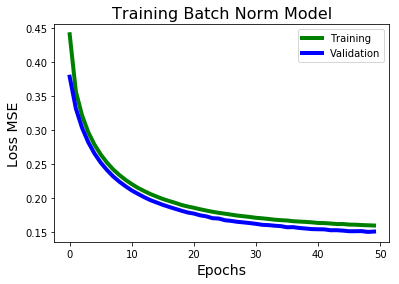

In [8]:
plt.plot(history.history['loss'], lw=4, label="Training", c='green')
plt.plot(history.history['val_loss'], lw=4, label="Validation", c='blue')
plt.xlabel('Epochs', size=14)
plt.ylabel('Loss MSE', size=14)
plt.title('Training Batch Norm Model', size=16)
plt.legend()
plt.show()

## Contractive Loss

In [20]:
hidden_names = ['encoded_1', 'encoded_2', 'decoded_1', 'decoded_2']

def contractive_loss(y_pred, y_true):
    mse = K.mean(K.square(y_true - y_pred), axis=1)
    contractive = mse
    lam = 1e-5
    
    for i in hidden_names:
        W = K.variable(value=model.get_layer(i).get_weights()[0])
        W = K.transpose(W)
        contractive += lam * K.sum(K.sum(W ** 2, axis=1), axis=0)


    return contractive

In [23]:
input_vector = Input(shape=(matrix_width, vector_length))
flatten = Flatten()(input_vector)
encoded = Dense(128, activation='relu', name='encoded_1')(flatten)
norm = BatchNormalization()(encoded)
encoded = Dense(64, activation='relu', name='encoded_2')(norm)
norm = BatchNormalization()(encoded)

decoded = Dense(128, activation='relu', name='decoded_1')(norm)
norm = BatchNormalization()(decoded)
decoded = Dense(vector_length, name='decoded_2')(norm)

contractive_model = Model(input_vector, decoded)

In [24]:
contractive_model.compile(optimizer='adadelta', loss=contractive_loss)
history_contractive = contractive_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(x_validate, y_validate), shuffle=True)

Train on 50000 samples, validate on 1500 samples
Epoch 1/50
42752/50000 [========================>.....] - ETA: 7:20 - loss: 0.589 - ETA: 4:17 - loss: 0.568 - ETA: 3:13 - loss: 0.563 - ETA: 2:39 - loss: 0.580 - ETA: 2:18 - loss: 0.572 - ETA: 2:03 - loss: 0.569 - ETA: 1:52 - loss: 0.568 - ETA: 1:44 - loss: 0.564 - ETA: 1:38 - loss: 0.562 - ETA: 1:34 - loss: 0.562 - ETA: 1:30 - loss: 0.562 - ETA: 1:26 - loss: 0.565 - ETA: 1:24 - loss: 0.564 - ETA: 1:22 - loss: 0.561 - ETA: 1:19 - loss: 0.561 - ETA: 1:17 - loss: 0.560 - ETA: 1:16 - loss: 0.559 - ETA: 1:14 - loss: 0.557 - ETA: 1:13 - loss: 0.553 - ETA: 1:12 - loss: 0.554 - ETA: 1:11 - loss: 0.557 - ETA: 1:10 - loss: 0.557 - ETA: 1:09 - loss: 0.557 - ETA: 1:08 - loss: 0.557 - ETA: 1:07 - loss: 0.555 - ETA: 1:06 - loss: 0.556 - ETA: 1:06 - loss: 0.554 - ETA: 1:05 - loss: 0.555 - ETA: 1:04 - loss: 0.556 - ETA: 1:04 - loss: 0.557 - ETA: 1:03 - loss: 0.555 - ETA: 1:03 - loss: 0.554 - ETA: 1:03 - loss: 0.552 - ETA: 1:02 - loss: 0.550 - ETA: 1:01

43520/50000 [=========================>....] - ETA: 1:00 - loss: 0.360 - ETA: 57s - loss: 0.391 - ETA: 55s - loss: 0.39 - ETA: 55s - loss: 0.38 - ETA: 55s - loss: 0.38 - ETA: 55s - loss: 0.38 - ETA: 54s - loss: 0.39 - ETA: 54s - loss: 0.39 - ETA: 54s - loss: 0.39 - ETA: 54s - loss: 0.39 - ETA: 54s - loss: 0.39 - ETA: 54s - loss: 0.39 - ETA: 53s - loss: 0.39 - ETA: 53s - loss: 0.39 - ETA: 53s - loss: 0.39 - ETA: 53s - loss: 0.39 - ETA: 53s - loss: 0.39 - ETA: 52s - loss: 0.39 - ETA: 52s - loss: 0.39 - ETA: 52s - loss: 0.39 - ETA: 52s - loss: 0.39 - ETA: 52s - loss: 0.39 - ETA: 52s - loss: 0.39 - ETA: 52s - loss: 0.39 - ETA: 51s - loss: 0.39 - ETA: 51s - loss: 0.39 - ETA: 51s - loss: 0.39 - ETA: 51s - loss: 0.39 - ETA: 51s - loss: 0.39 - ETA: 51s - loss: 0.39 - ETA: 50s - loss: 0.39 - ETA: 50s - loss: 0.39 - ETA: 50s - loss: 0.39 - ETA: 50s - loss: 0.39 - ETA: 50s - loss: 0.38 - ETA: 50s - loss: 0.38 - ETA: 50s - loss: 0.39 - ETA: 49s - loss: 0.39 - ETA: 49s - loss: 0.39 - ETA: 49s - los

50000/50000 [==============================] - ETA: 7s - loss: 0.370 - ETA: 7s - loss: 0.370 - ETA: 6s - loss: 0.370 - ETA: 6s - loss: 0.370 - ETA: 6s - loss: 0.370 - ETA: 6s - loss: 0.370 - ETA: 6s - loss: 0.370 - ETA: 6s - loss: 0.370 - ETA: 6s - loss: 0.370 - ETA: 5s - loss: 0.370 - ETA: 5s - loss: 0.370 - ETA: 5s - loss: 0.369 - ETA: 5s - loss: 0.369 - ETA: 5s - loss: 0.369 - ETA: 5s - loss: 0.369 - ETA: 5s - loss: 0.369 - ETA: 4s - loss: 0.369 - ETA: 4s - loss: 0.369 - ETA: 4s - loss: 0.369 - ETA: 4s - loss: 0.369 - ETA: 4s - loss: 0.369 - ETA: 4s - loss: 0.369 - ETA: 4s - loss: 0.369 - ETA: 3s - loss: 0.369 - ETA: 3s - loss: 0.369 - ETA: 3s - loss: 0.369 - ETA: 3s - loss: 0.369 - ETA: 3s - loss: 0.369 - ETA: 3s - loss: 0.369 - ETA: 3s - loss: 0.369 - ETA: 2s - loss: 0.369 - ETA: 2s - loss: 0.369 - ETA: 2s - loss: 0.369 - ETA: 2s - loss: 0.368 - ETA: 2s - loss: 0.368 - ETA: 2s - loss: 0.368 - ETA: 2s - loss: 0.368 - ETA: 1s - loss: 0.368 - ETA: 1s - loss: 0.368 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 53s - loss: 0.31 - ETA: 53s - loss: 0.31 - ETA: 52s - loss: 0.32 - ETA: 52s - loss: 0.32 - ETA: 52s - loss: 0.32 - ETA: 52s - loss: 0.32 - ETA: 51s - loss: 0.32 - ETA: 52s - loss: 0.32 - ETA: 52s - loss: 0.32 - ETA: 52s - loss: 0.31 - ETA: 52s - loss: 0.31 - ETA: 52s - loss: 0.31 - ETA: 52s - loss: 0.31 - ETA: 52s - loss: 0.31 - ETA: 52s - loss: 0.31 - ETA: 53s - loss: 0.31 - ETA: 53s - loss: 0.31 - ETA: 54s - loss: 0.31 - ETA: 53s - loss: 0.31 - ETA: 53s - loss: 0.31 - ETA: 53s - loss: 0.31 - ETA: 53s - loss: 0.31 - ETA: 52s - loss: 0.31 - ETA: 52s - loss: 0.31 - ETA: 52s - loss: 0.31 - ETA: 52s - loss: 0.31 - ETA: 52s - loss: 0.31 - ETA: 52s - loss: 0.31 - ETA: 52s - loss: 0.31 - ETA: 51s - loss: 0.31 - ETA: 51s - loss: 0.31 - ETA: 51s - loss: 0.31 - ETA: 51s - loss: 0.31 - ETA: 51s - loss: 0.31 - ETA: 51s - loss: 0.31 - ETA: 50s - loss: 0.31 - ETA: 50s - loss: 0.31 - ETA: 50s - loss: 0.31 - ETA: 50s - loss: 0.31 - ETA: 50s - loss: 

50000/50000 [==============================] - ETA: 7s - loss: 0.310 - ETA: 6s - loss: 0.310 - ETA: 6s - loss: 0.309 - ETA: 6s - loss: 0.309 - ETA: 6s - loss: 0.309 - ETA: 6s - loss: 0.309 - ETA: 6s - loss: 0.309 - ETA: 6s - loss: 0.309 - ETA: 5s - loss: 0.309 - ETA: 5s - loss: 0.309 - ETA: 5s - loss: 0.309 - ETA: 5s - loss: 0.309 - ETA: 5s - loss: 0.309 - ETA: 5s - loss: 0.309 - ETA: 5s - loss: 0.309 - ETA: 4s - loss: 0.309 - ETA: 4s - loss: 0.309 - ETA: 4s - loss: 0.309 - ETA: 4s - loss: 0.309 - ETA: 4s - loss: 0.309 - ETA: 4s - loss: 0.309 - ETA: 4s - loss: 0.309 - ETA: 3s - loss: 0.309 - ETA: 3s - loss: 0.309 - ETA: 3s - loss: 0.309 - ETA: 3s - loss: 0.309 - ETA: 3s - loss: 0.308 - ETA: 3s - loss: 0.309 - ETA: 3s - loss: 0.308 - ETA: 2s - loss: 0.308 - ETA: 2s - loss: 0.308 - ETA: 2s - loss: 0.309 - ETA: 2s - loss: 0.309 - ETA: 2s - loss: 0.309 - ETA: 2s - loss: 0.309 - ETA: 2s - loss: 0.308 - ETA: 1s - loss: 0.308 - ETA: 1s - loss: 0.308 - ETA: 1s - loss: 0.308 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 51s - loss: 0.28 - ETA: 51s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 53s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 51s - loss: 0.27 - ETA: 51s - loss: 0.27 - ETA: 51s - loss: 0.27 - ETA: 51s - loss: 0.28 - ETA: 51s - loss: 0.28 - ETA: 51s - loss: 0.28 - ETA: 50s - loss: 0.28 - ETA: 50s - loss: 0.28 - ETA: 50s - loss: 0.28 - ETA: 50s - loss: 0.28 - ETA: 50s - loss: 0.28 - ETA: 50s - loss: 0.28 - ETA: 50s - loss: 0.28 - ETA: 50s - loss: 0.28 - ETA: 49s - loss: 0.28 - ETA: 49s - loss: 0.28 - ETA: 49s - loss: 0.28 - ETA: 49s - loss: 0.28 - ETA: 49s - loss: 0.28 - ETA: 49s - loss: 0.28 - ETA: 49s - loss: 0.28 - ETA: 49s - loss: 0.28 - ETA: 49s - loss: 0.28 - ETA: 49s - loss: 0.28 - ETA: 49s - loss: 0.28 - ETA: 49s - loss: 0.28 - ETA: 49s - loss: 0.28 - ETA: 48s - loss: 0.28 - ETA: 48s - loss: 0.28 - ETA: 48s - loss: 0.28 - ETA: 48s - loss: 0.28 - ETA: 48s - loss: 

50000/50000 [==============================] - ETA: 6s - loss: 0.275 - ETA: 6s - loss: 0.275 - ETA: 6s - loss: 0.275 - ETA: 6s - loss: 0.275 - ETA: 6s - loss: 0.275 - ETA: 6s - loss: 0.275 - ETA: 6s - loss: 0.275 - ETA: 5s - loss: 0.275 - ETA: 5s - loss: 0.275 - ETA: 5s - loss: 0.275 - ETA: 5s - loss: 0.275 - ETA: 5s - loss: 0.275 - ETA: 5s - loss: 0.275 - ETA: 5s - loss: 0.275 - ETA: 5s - loss: 0.275 - ETA: 4s - loss: 0.275 - ETA: 4s - loss: 0.275 - ETA: 4s - loss: 0.275 - ETA: 4s - loss: 0.275 - ETA: 4s - loss: 0.275 - ETA: 4s - loss: 0.275 - ETA: 4s - loss: 0.275 - ETA: 3s - loss: 0.275 - ETA: 3s - loss: 0.275 - ETA: 3s - loss: 0.275 - ETA: 3s - loss: 0.275 - ETA: 3s - loss: 0.275 - ETA: 3s - loss: 0.275 - ETA: 3s - loss: 0.275 - ETA: 2s - loss: 0.275 - ETA: 2s - loss: 0.275 - ETA: 2s - loss: 0.275 - ETA: 2s - loss: 0.275 - ETA: 2s - loss: 0.275 - ETA: 2s - loss: 0.275 - ETA: 2s - loss: 0.275 - ETA: 1s - loss: 0.275 - ETA: 1s - loss: 0.275 - ETA: 1s - loss: 0.275 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 52s - loss: 0.27 - ETA: 52s - loss: 0.26 - ETA: 51s - loss: 0.25 - ETA: 51s - loss: 0.25 - ETA: 52s - loss: 0.25 - ETA: 52s - loss: 0.25 - ETA: 51s - loss: 0.25 - ETA: 51s - loss: 0.25 - ETA: 51s - loss: 0.25 - ETA: 51s - loss: 0.25 - ETA: 51s - loss: 0.25 - ETA: 51s - loss: 0.25 - ETA: 51s - loss: 0.25 - ETA: 51s - loss: 0.25 - ETA: 51s - loss: 0.25 - ETA: 51s - loss: 0.25 - ETA: 51s - loss: 0.25 - ETA: 51s - loss: 0.25 - ETA: 50s - loss: 0.25 - ETA: 50s - loss: 0.25 - ETA: 50s - loss: 0.25 - ETA: 50s - loss: 0.25 - ETA: 50s - loss: 0.25 - ETA: 50s - loss: 0.25 - ETA: 50s - loss: 0.25 - ETA: 49s - loss: 0.25 - ETA: 49s - loss: 0.25 - ETA: 49s - loss: 0.25 - ETA: 49s - loss: 0.25 - ETA: 49s - loss: 0.25 - ETA: 49s - loss: 0.25 - ETA: 48s - loss: 0.25 - ETA: 48s - loss: 0.25 - ETA: 48s - loss: 0.25 - ETA: 48s - loss: 0.25 - ETA: 48s - loss: 0.25 - ETA: 48s - loss: 0.25 - ETA: 48s - loss: 0.25 - ETA: 48s - loss: 0.25 - ETA: 48s - loss: 

50000/50000 [==============================] - ETA: 6s - loss: 0.254 - ETA: 6s - loss: 0.254 - ETA: 6s - loss: 0.254 - ETA: 6s - loss: 0.254 - ETA: 6s - loss: 0.254 - ETA: 6s - loss: 0.254 - ETA: 6s - loss: 0.254 - ETA: 5s - loss: 0.254 - ETA: 5s - loss: 0.254 - ETA: 5s - loss: 0.254 - ETA: 5s - loss: 0.253 - ETA: 5s - loss: 0.253 - ETA: 5s - loss: 0.253 - ETA: 5s - loss: 0.253 - ETA: 4s - loss: 0.253 - ETA: 4s - loss: 0.253 - ETA: 4s - loss: 0.253 - ETA: 4s - loss: 0.253 - ETA: 4s - loss: 0.253 - ETA: 4s - loss: 0.253 - ETA: 4s - loss: 0.253 - ETA: 3s - loss: 0.253 - ETA: 3s - loss: 0.253 - ETA: 3s - loss: 0.253 - ETA: 3s - loss: 0.253 - ETA: 3s - loss: 0.253 - ETA: 3s - loss: 0.253 - ETA: 3s - loss: 0.253 - ETA: 2s - loss: 0.253 - ETA: 2s - loss: 0.253 - ETA: 2s - loss: 0.253 - ETA: 2s - loss: 0.253 - ETA: 2s - loss: 0.253 - ETA: 2s - loss: 0.253 - ETA: 2s - loss: 0.253 - ETA: 2s - loss: 0.253 - ETA: 1s - loss: 0.253 - ETA: 1s - loss: 0.253 - ETA: 1s - loss: 0.253 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 53s - loss: 0.25 - ETA: 53s - loss: 0.23 - ETA: 52s - loss: 0.24 - ETA: 52s - loss: 0.23 - ETA: 52s - loss: 0.23 - ETA: 52s - loss: 0.23 - ETA: 51s - loss: 0.23 - ETA: 51s - loss: 0.23 - ETA: 51s - loss: 0.23 - ETA: 51s - loss: 0.23 - ETA: 51s - loss: 0.23 - ETA: 51s - loss: 0.23 - ETA: 51s - loss: 0.23 - ETA: 51s - loss: 0.23 - ETA: 51s - loss: 0.23 - ETA: 51s - loss: 0.23 - ETA: 50s - loss: 0.23 - ETA: 50s - loss: 0.23 - ETA: 50s - loss: 0.23 - ETA: 50s - loss: 0.23 - ETA: 50s - loss: 0.23 - ETA: 50s - loss: 0.23 - ETA: 50s - loss: 0.23 - ETA: 50s - loss: 0.23 - ETA: 49s - loss: 0.24 - ETA: 49s - loss: 0.24 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.24 - ETA: 49s - loss: 0.24 - ETA: 49s - loss: 0.24 - ETA: 49s - loss: 0.24 - ETA: 48s - loss: 0.24 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 47s - loss: 

50000/50000 [==============================] - ETA: 6s - loss: 0.238 - ETA: 6s - loss: 0.238 - ETA: 6s - loss: 0.238 - ETA: 6s - loss: 0.238 - ETA: 6s - loss: 0.238 - ETA: 6s - loss: 0.238 - ETA: 6s - loss: 0.238 - ETA: 5s - loss: 0.238 - ETA: 5s - loss: 0.238 - ETA: 5s - loss: 0.238 - ETA: 5s - loss: 0.238 - ETA: 5s - loss: 0.238 - ETA: 5s - loss: 0.238 - ETA: 5s - loss: 0.238 - ETA: 4s - loss: 0.238 - ETA: 4s - loss: 0.238 - ETA: 4s - loss: 0.238 - ETA: 4s - loss: 0.238 - ETA: 4s - loss: 0.238 - ETA: 4s - loss: 0.238 - ETA: 4s - loss: 0.238 - ETA: 3s - loss: 0.238 - ETA: 3s - loss: 0.238 - ETA: 3s - loss: 0.238 - ETA: 3s - loss: 0.238 - ETA: 3s - loss: 0.238 - ETA: 3s - loss: 0.238 - ETA: 3s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 2s - loss: 0.238 - ETA: 1s - loss: 0.238 - ETA: 1s - loss: 0.238 - ETA: 1s - loss: 0.238 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 51s - loss: 0.22 - ETA: 51s - loss: 0.22 - ETA: 52s - loss: 0.22 - ETA: 52s - loss: 0.22 - ETA: 52s - loss: 0.22 - ETA: 52s - loss: 0.22 - ETA: 52s - loss: 0.22 - ETA: 52s - loss: 0.22 - ETA: 51s - loss: 0.22 - ETA: 51s - loss: 0.22 - ETA: 51s - loss: 0.22 - ETA: 51s - loss: 0.22 - ETA: 51s - loss: 0.22 - ETA: 51s - loss: 0.22 - ETA: 51s - loss: 0.22 - ETA: 51s - loss: 0.22 - ETA: 51s - loss: 0.22 - ETA: 50s - loss: 0.22 - ETA: 50s - loss: 0.22 - ETA: 50s - loss: 0.22 - ETA: 50s - loss: 0.22 - ETA: 50s - loss: 0.22 - ETA: 50s - loss: 0.22 - ETA: 50s - loss: 0.22 - ETA: 50s - loss: 0.22 - ETA: 50s - loss: 0.22 - ETA: 49s - loss: 0.22 - ETA: 49s - loss: 0.22 - ETA: 49s - loss: 0.22 - ETA: 49s - loss: 0.22 - ETA: 49s - loss: 0.22 - ETA: 48s - loss: 0.22 - ETA: 48s - loss: 0.22 - ETA: 48s - loss: 0.22 - ETA: 48s - loss: 0.22 - ETA: 48s - loss: 0.22 - ETA: 48s - loss: 0.22 - ETA: 48s - loss: 0.22 - ETA: 47s - loss: 0.22 - ETA: 47s - loss: 

50000/50000 [==============================] - ETA: 7s - loss: 0.227 - ETA: 7s - loss: 0.227 - ETA: 7s - loss: 0.227 - ETA: 6s - loss: 0.227 - ETA: 6s - loss: 0.227 - ETA: 6s - loss: 0.227 - ETA: 6s - loss: 0.227 - ETA: 6s - loss: 0.227 - ETA: 6s - loss: 0.227 - ETA: 5s - loss: 0.227 - ETA: 5s - loss: 0.227 - ETA: 5s - loss: 0.227 - ETA: 5s - loss: 0.227 - ETA: 5s - loss: 0.227 - ETA: 5s - loss: 0.227 - ETA: 5s - loss: 0.227 - ETA: 4s - loss: 0.227 - ETA: 4s - loss: 0.227 - ETA: 4s - loss: 0.227 - ETA: 4s - loss: 0.227 - ETA: 4s - loss: 0.227 - ETA: 4s - loss: 0.227 - ETA: 4s - loss: 0.227 - ETA: 3s - loss: 0.227 - ETA: 3s - loss: 0.227 - ETA: 3s - loss: 0.227 - ETA: 3s - loss: 0.227 - ETA: 3s - loss: 0.227 - ETA: 3s - loss: 0.227 - ETA: 3s - loss: 0.227 - ETA: 2s - loss: 0.227 - ETA: 2s - loss: 0.227 - ETA: 2s - loss: 0.227 - ETA: 2s - loss: 0.227 - ETA: 2s - loss: 0.227 - ETA: 2s - loss: 0.227 - ETA: 2s - loss: 0.227 - ETA: 1s - loss: 0.227 - ETA: 1s - loss: 0.227 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 56s - loss: 0.20 - ETA: 56s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 54s - loss: 0.21 - ETA: 54s - loss: 0.21 - ETA: 54s - loss: 0.21 - ETA: 53s - loss: 0.21 - ETA: 53s - loss: 0.22 - ETA: 53s - loss: 0.22 - ETA: 52s - loss: 0.22 - ETA: 52s - loss: 0.22 - ETA: 52s - loss: 0.22 - ETA: 52s - loss: 0.22 - ETA: 52s - loss: 0.22 - ETA: 51s - loss: 0.22 - ETA: 51s - loss: 0.22 - ETA: 51s - loss: 0.22 - ETA: 52s - loss: 0.22 - ETA: 51s - loss: 0.22 - ETA: 53s - loss: 0.22 - ETA: 53s - loss: 0.22 - ETA: 54s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 54s - loss: 0.22 - ETA: 54s - loss: 0.22 - ETA: 54s - loss: 0.22 - ETA: 54s - loss: 0.22 - ETA: 54s - loss: 0.22 - ETA: 53s - loss: 0.22 - ETA: 53s - loss: 0.22 - ETA: 53s - loss: 

50000/50000 [==============================] - ETA: 7s - loss: 0.218 - ETA: 7s - loss: 0.218 - ETA: 7s - loss: 0.218 - ETA: 6s - loss: 0.218 - ETA: 6s - loss: 0.218 - ETA: 6s - loss: 0.218 - ETA: 6s - loss: 0.218 - ETA: 6s - loss: 0.218 - ETA: 6s - loss: 0.218 - ETA: 6s - loss: 0.218 - ETA: 5s - loss: 0.218 - ETA: 5s - loss: 0.218 - ETA: 5s - loss: 0.218 - ETA: 5s - loss: 0.218 - ETA: 5s - loss: 0.218 - ETA: 5s - loss: 0.218 - ETA: 4s - loss: 0.218 - ETA: 4s - loss: 0.218 - ETA: 4s - loss: 0.218 - ETA: 4s - loss: 0.218 - ETA: 4s - loss: 0.218 - ETA: 4s - loss: 0.218 - ETA: 4s - loss: 0.218 - ETA: 3s - loss: 0.218 - ETA: 3s - loss: 0.218 - ETA: 3s - loss: 0.218 - ETA: 3s - loss: 0.218 - ETA: 3s - loss: 0.218 - ETA: 3s - loss: 0.218 - ETA: 3s - loss: 0.218 - ETA: 2s - loss: 0.218 - ETA: 2s - loss: 0.218 - ETA: 2s - loss: 0.218 - ETA: 2s - loss: 0.218 - ETA: 2s - loss: 0.218 - ETA: 2s - loss: 0.218 - ETA: 2s - loss: 0.218 - ETA: 1s - loss: 0.218 - ETA: 1s - loss: 0.218 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 56s - loss: 0.20 - ETA: 57s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 58s - loss: 0.21 - ETA: 58s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 58s - loss: 0.21 - ETA: 58s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 54s - loss: 0.21 - ETA: 54s - loss: 0.21 - ETA: 54s - loss: 0.21 - ETA: 54s - loss: 0.21 - ETA: 54s - loss: 0.21 - ETA: 54s - loss: 0.21 - ETA: 54s - loss: 0.21 - ETA: 53s - loss: 0.21 - ETA: 53s - loss: 

50000/50000 [==============================] - ETA: 7s - loss: 0.211 - ETA: 7s - loss: 0.211 - ETA: 7s - loss: 0.211 - ETA: 6s - loss: 0.211 - ETA: 6s - loss: 0.211 - ETA: 6s - loss: 0.211 - ETA: 6s - loss: 0.211 - ETA: 6s - loss: 0.211 - ETA: 6s - loss: 0.211 - ETA: 6s - loss: 0.211 - ETA: 5s - loss: 0.211 - ETA: 5s - loss: 0.211 - ETA: 5s - loss: 0.211 - ETA: 5s - loss: 0.211 - ETA: 5s - loss: 0.211 - ETA: 5s - loss: 0.211 - ETA: 4s - loss: 0.211 - ETA: 4s - loss: 0.211 - ETA: 4s - loss: 0.211 - ETA: 4s - loss: 0.211 - ETA: 4s - loss: 0.211 - ETA: 4s - loss: 0.211 - ETA: 4s - loss: 0.211 - ETA: 3s - loss: 0.211 - ETA: 3s - loss: 0.211 - ETA: 3s - loss: 0.211 - ETA: 3s - loss: 0.211 - ETA: 3s - loss: 0.211 - ETA: 3s - loss: 0.211 - ETA: 3s - loss: 0.211 - ETA: 2s - loss: 0.211 - ETA: 2s - loss: 0.211 - ETA: 2s - loss: 0.211 - ETA: 2s - loss: 0.211 - ETA: 2s - loss: 0.211 - ETA: 2s - loss: 0.211 - ETA: 2s - loss: 0.211 - ETA: 1s - loss: 0.211 - ETA: 1s - loss: 0.211 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 51s - loss: 0.20 - ETA: 53s - loss: 0.20 - ETA: 53s - loss: 0.20 - ETA: 52s - loss: 0.20 - ETA: 52s - loss: 0.21 - ETA: 51s - loss: 0.21 - ETA: 51s - loss: 0.21 - ETA: 52s - loss: 0.21 - ETA: 51s - loss: 0.21 - ETA: 52s - loss: 0.20 - ETA: 52s - loss: 0.20 - ETA: 51s - loss: 0.20 - ETA: 51s - loss: 0.20 - ETA: 51s - loss: 0.20 - ETA: 51s - loss: 0.20 - ETA: 51s - loss: 0.20 - ETA: 51s - loss: 0.20 - ETA: 51s - loss: 0.20 - ETA: 50s - loss: 0.20 - ETA: 50s - loss: 0.20 - ETA: 50s - loss: 0.20 - ETA: 50s - loss: 0.20 - ETA: 50s - loss: 0.20 - ETA: 50s - loss: 0.20 - ETA: 50s - loss: 0.20 - ETA: 50s - loss: 0.20 - ETA: 50s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 49s - loss: 0.20 - ETA: 48s - loss: 0.20 - ETA: 48s - loss: 0.20 - ETA: 48s - loss: 0.20 - ETA: 48s - loss: 

50000/50000 [==============================] - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 2s - loss: 0.205 - ETA: 2s - loss: 0.205 - ETA: 2s - loss: 0.205 - ETA: 2s - loss: 0.205 - ETA: 2s - loss: 0.205 - ETA: 2s - loss: 0.205 - ETA: 2s - loss: 0.205 - ETA: 1s - loss: 0.205 - ETA: 1s - loss: 0.205 - ETA: 1s - loss: 0.205 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 53s - loss: 0.19 - ETA: 53s - loss: 0.19 - ETA: 53s - loss: 0.19 - ETA: 54s - loss: 0.19 - ETA: 53s - loss: 0.19 - ETA: 53s - loss: 0.19 - ETA: 53s - loss: 0.19 - ETA: 53s - loss: 0.19 - ETA: 53s - loss: 0.19 - ETA: 53s - loss: 0.19 - ETA: 53s - loss: 0.19 - ETA: 53s - loss: 0.19 - ETA: 53s - loss: 0.19 - ETA: 53s - loss: 0.19 - ETA: 52s - loss: 0.19 - ETA: 52s - loss: 0.19 - ETA: 52s - loss: 0.19 - ETA: 52s - loss: 0.19 - ETA: 52s - loss: 0.19 - ETA: 52s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 

50000/50000 [==============================] - ETA: 7s - loss: 0.200 - ETA: 7s - loss: 0.200 - ETA: 6s - loss: 0.200 - ETA: 6s - loss: 0.200 - ETA: 6s - loss: 0.200 - ETA: 6s - loss: 0.200 - ETA: 6s - loss: 0.200 - ETA: 6s - loss: 0.200 - ETA: 6s - loss: 0.200 - ETA: 5s - loss: 0.200 - ETA: 5s - loss: 0.200 - ETA: 5s - loss: 0.200 - ETA: 5s - loss: 0.200 - ETA: 5s - loss: 0.200 - ETA: 5s - loss: 0.200 - ETA: 5s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 2s - loss: 0.200 - ETA: 2s - loss: 0.200 - ETA: 2s - loss: 0.200 - ETA: 2s - loss: 0.200 - ETA: 2s - loss: 0.200 - ETA: 2s - loss: 0.200 - ETA: 2s - loss: 0.200 - ETA: 1s - loss: 0.200 - ETA: 1s - loss: 0.200 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 51s - loss: 0.19 - ETA: 52s - loss: 0.20 - ETA: 53s - loss: 0.21 - ETA: 53s - loss: 0.20 - ETA: 53s - loss: 0.20 - ETA: 52s - loss: 0.20 - ETA: 52s - loss: 0.19 - ETA: 52s - loss: 0.20 - ETA: 52s - loss: 0.19 - ETA: 52s - loss: 0.19 - ETA: 52s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 48s - loss: 0.19 - ETA: 48s - loss: 0.19 - ETA: 48s - loss: 0.19 - ETA: 48s - loss: 0.19 - ETA: 48s - loss: 0.19 - ETA: 48s - loss: 0.19 - ETA: 48s - loss: 0.19 - ETA: 47s - loss: 0.19 - ETA: 47s - loss: 

50000/50000 [==============================] - ETA: 6s - loss: 0.195 - ETA: 6s - loss: 0.195 - ETA: 6s - loss: 0.195 - ETA: 6s - loss: 0.195 - ETA: 6s - loss: 0.195 - ETA: 6s - loss: 0.195 - ETA: 5s - loss: 0.195 - ETA: 5s - loss: 0.195 - ETA: 5s - loss: 0.195 - ETA: 5s - loss: 0.195 - ETA: 5s - loss: 0.195 - ETA: 5s - loss: 0.195 - ETA: 5s - loss: 0.195 - ETA: 5s - loss: 0.195 - ETA: 4s - loss: 0.195 - ETA: 4s - loss: 0.195 - ETA: 4s - loss: 0.195 - ETA: 4s - loss: 0.195 - ETA: 4s - loss: 0.195 - ETA: 4s - loss: 0.195 - ETA: 4s - loss: 0.195 - ETA: 3s - loss: 0.195 - ETA: 3s - loss: 0.195 - ETA: 3s - loss: 0.195 - ETA: 3s - loss: 0.195 - ETA: 3s - loss: 0.195 - ETA: 3s - loss: 0.195 - ETA: 3s - loss: 0.195 - ETA: 2s - loss: 0.195 - ETA: 2s - loss: 0.195 - ETA: 2s - loss: 0.195 - ETA: 2s - loss: 0.195 - ETA: 2s - loss: 0.195 - ETA: 2s - loss: 0.195 - ETA: 2s - loss: 0.195 - ETA: 2s - loss: 0.195 - ETA: 1s - loss: 0.195 - ETA: 1s - loss: 0.195 - ETA: 1s - loss: 0.195 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 53s - loss: 0.19 - ETA: 52s - loss: 0.19 - ETA: 52s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 52s - loss: 0.19 - ETA: 52s - loss: 0.19 - ETA: 52s - loss: 0.20 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 48s - loss: 0.19 - ETA: 48s - loss: 0.19 - ETA: 48s - loss: 0.19 - ETA: 48s - loss: 0.19 - ETA: 48s - loss: 0.19 - ETA: 48s - loss: 0.19 - ETA: 48s - loss: 0.19 - ETA: 48s - loss: 0.19 - ETA: 47s - loss: 

50000/50000 [==============================] - ETA: 6s - loss: 0.192 - ETA: 6s - loss: 0.192 - ETA: 6s - loss: 0.192 - ETA: 6s - loss: 0.192 - ETA: 6s - loss: 0.192 - ETA: 6s - loss: 0.192 - ETA: 5s - loss: 0.192 - ETA: 5s - loss: 0.192 - ETA: 5s - loss: 0.192 - ETA: 5s - loss: 0.192 - ETA: 5s - loss: 0.192 - ETA: 5s - loss: 0.192 - ETA: 5s - loss: 0.192 - ETA: 5s - loss: 0.192 - ETA: 4s - loss: 0.192 - ETA: 4s - loss: 0.192 - ETA: 4s - loss: 0.192 - ETA: 4s - loss: 0.192 - ETA: 4s - loss: 0.192 - ETA: 4s - loss: 0.192 - ETA: 4s - loss: 0.192 - ETA: 3s - loss: 0.192 - ETA: 3s - loss: 0.192 - ETA: 3s - loss: 0.192 - ETA: 3s - loss: 0.192 - ETA: 3s - loss: 0.192 - ETA: 3s - loss: 0.192 - ETA: 3s - loss: 0.192 - ETA: 2s - loss: 0.192 - ETA: 2s - loss: 0.192 - ETA: 2s - loss: 0.192 - ETA: 2s - loss: 0.192 - ETA: 2s - loss: 0.192 - ETA: 2s - loss: 0.192 - ETA: 2s - loss: 0.192 - ETA: 2s - loss: 0.192 - ETA: 1s - loss: 0.192 - ETA: 1s - loss: 0.192 - ETA: 1s - loss: 0.192 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 53s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 48s - loss: 0.18 - ETA: 48s - loss: 0.18 - ETA: 48s - loss: 0.18 - ETA: 48s - loss: 0.18 - ETA: 48s - loss: 0.18 - ETA: 48s - loss: 0.18 - ETA: 48s - loss: 

50000/50000 [==============================] - ETA: 6s - loss: 0.188 - ETA: 6s - loss: 0.188 - ETA: 6s - loss: 0.188 - ETA: 6s - loss: 0.188 - ETA: 6s - loss: 0.188 - ETA: 6s - loss: 0.188 - ETA: 6s - loss: 0.188 - ETA: 6s - loss: 0.188 - ETA: 5s - loss: 0.188 - ETA: 5s - loss: 0.188 - ETA: 5s - loss: 0.188 - ETA: 5s - loss: 0.188 - ETA: 5s - loss: 0.188 - ETA: 5s - loss: 0.188 - ETA: 5s - loss: 0.188 - ETA: 4s - loss: 0.188 - ETA: 4s - loss: 0.188 - ETA: 4s - loss: 0.188 - ETA: 4s - loss: 0.188 - ETA: 4s - loss: 0.188 - ETA: 4s - loss: 0.188 - ETA: 4s - loss: 0.188 - ETA: 3s - loss: 0.188 - ETA: 3s - loss: 0.188 - ETA: 3s - loss: 0.188 - ETA: 3s - loss: 0.188 - ETA: 3s - loss: 0.188 - ETA: 3s - loss: 0.188 - ETA: 3s - loss: 0.188 - ETA: 2s - loss: 0.188 - ETA: 2s - loss: 0.188 - ETA: 2s - loss: 0.188 - ETA: 2s - loss: 0.188 - ETA: 2s - loss: 0.188 - ETA: 2s - loss: 0.188 - ETA: 2s - loss: 0.188 - ETA: 1s - loss: 0.188 - ETA: 1s - loss: 0.188 - ETA: 1s - loss: 0.188 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 52s - loss: 0.17 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.19 - ETA: 52s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.18 - ETA: 54s - loss: 0.18 - ETA: 53s - loss: 0.18 - ETA: 53s - loss: 0.18 - ETA: 53s - loss: 0.18 - ETA: 53s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 

50000/50000 [==============================] - ETA: 7s - loss: 0.186 - ETA: 7s - loss: 0.186 - ETA: 6s - loss: 0.186 - ETA: 6s - loss: 0.186 - ETA: 6s - loss: 0.186 - ETA: 6s - loss: 0.186 - ETA: 6s - loss: 0.186 - ETA: 6s - loss: 0.186 - ETA: 6s - loss: 0.186 - ETA: 5s - loss: 0.186 - ETA: 5s - loss: 0.186 - ETA: 5s - loss: 0.186 - ETA: 5s - loss: 0.186 - ETA: 5s - loss: 0.186 - ETA: 5s - loss: 0.186 - ETA: 5s - loss: 0.186 - ETA: 4s - loss: 0.186 - ETA: 4s - loss: 0.186 - ETA: 4s - loss: 0.186 - ETA: 4s - loss: 0.186 - ETA: 4s - loss: 0.186 - ETA: 4s - loss: 0.186 - ETA: 4s - loss: 0.186 - ETA: 3s - loss: 0.186 - ETA: 3s - loss: 0.186 - ETA: 3s - loss: 0.186 - ETA: 3s - loss: 0.186 - ETA: 3s - loss: 0.186 - ETA: 3s - loss: 0.186 - ETA: 2s - loss: 0.186 - ETA: 2s - loss: 0.186 - ETA: 2s - loss: 0.186 - ETA: 2s - loss: 0.186 - ETA: 2s - loss: 0.186 - ETA: 2s - loss: 0.186 - ETA: 2s - loss: 0.186 - ETA: 1s - loss: 0.186 - ETA: 1s - loss: 0.186 - ETA: 1s - loss: 0.186 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 55s - loss: 0.19 - ETA: 54s - loss: 0.19 - ETA: 55s - loss: 0.19 - ETA: 54s - loss: 0.18 - ETA: 54s - loss: 0.18 - ETA: 53s - loss: 0.18 - ETA: 54s - loss: 0.18 - ETA: 54s - loss: 0.18 - ETA: 53s - loss: 0.18 - ETA: 53s - loss: 0.18 - ETA: 53s - loss: 0.18 - ETA: 53s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 48s - loss: 0.18 - ETA: 48s - loss: 0.18 - ETA: 48s - loss: 

50000/50000 [==============================] - ETA: 6s - loss: 0.184 - ETA: 6s - loss: 0.184 - ETA: 6s - loss: 0.184 - ETA: 6s - loss: 0.184 - ETA: 6s - loss: 0.184 - ETA: 6s - loss: 0.184 - ETA: 6s - loss: 0.183 - ETA: 5s - loss: 0.183 - ETA: 5s - loss: 0.183 - ETA: 5s - loss: 0.183 - ETA: 5s - loss: 0.183 - ETA: 5s - loss: 0.183 - ETA: 5s - loss: 0.183 - ETA: 5s - loss: 0.183 - ETA: 4s - loss: 0.183 - ETA: 4s - loss: 0.184 - ETA: 4s - loss: 0.183 - ETA: 4s - loss: 0.183 - ETA: 4s - loss: 0.183 - ETA: 4s - loss: 0.183 - ETA: 4s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.184 - ETA: 3s - loss: 0.184 - ETA: 3s - loss: 0.184 - ETA: 3s - loss: 0.184 - ETA: 3s - loss: 0.184 - ETA: 3s - loss: 0.184 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.184 - ETA: 2s - loss: 0.184 - ETA: 2s - loss: 0.184 - ETA: 2s - loss: 0.184 - ETA: 2s - loss: 0.184 - ETA: 2s - loss: 0.184 - ETA: 1s - loss: 0.184 - ETA: 1s - loss: 0.184 - ETA: 1s - loss: 0.184 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 52s - loss: 0.18 - ETA: 54s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 53s - loss: 0.18 - ETA: 52s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 53s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.18 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 50s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 48s - loss: 0.18 - ETA: 48s - loss: 0.18 - ETA: 48s - loss: 0.18 - ETA: 48s - loss: 

50000/50000 [==============================] - ETA: 6s - loss: 0.182 - ETA: 6s - loss: 0.182 - ETA: 6s - loss: 0.182 - ETA: 6s - loss: 0.182 - ETA: 6s - loss: 0.182 - ETA: 6s - loss: 0.182 - ETA: 6s - loss: 0.182 - ETA: 5s - loss: 0.182 - ETA: 5s - loss: 0.182 - ETA: 5s - loss: 0.182 - ETA: 5s - loss: 0.182 - ETA: 5s - loss: 0.182 - ETA: 5s - loss: 0.182 - ETA: 5s - loss: 0.182 - ETA: 4s - loss: 0.182 - ETA: 4s - loss: 0.182 - ETA: 4s - loss: 0.182 - ETA: 4s - loss: 0.182 - ETA: 4s - loss: 0.182 - ETA: 4s - loss: 0.182 - ETA: 4s - loss: 0.182 - ETA: 3s - loss: 0.182 - ETA: 3s - loss: 0.182 - ETA: 3s - loss: 0.182 - ETA: 3s - loss: 0.182 - ETA: 3s - loss: 0.182 - ETA: 3s - loss: 0.182 - ETA: 3s - loss: 0.182 - ETA: 3s - loss: 0.182 - ETA: 2s - loss: 0.182 - ETA: 2s - loss: 0.182 - ETA: 2s - loss: 0.182 - ETA: 2s - loss: 0.182 - ETA: 2s - loss: 0.182 - ETA: 2s - loss: 0.182 - ETA: 2s - loss: 0.182 - ETA: 1s - loss: 0.182 - ETA: 1s - loss: 0.182 - ETA: 1s - loss: 0.182 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 53s - loss: 0.17 - ETA: 54s - loss: 0.18 - ETA: 53s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 53s - loss: 0.18 - ETA: 53s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 51s - loss: 0.18 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 48s - loss: 0.17 - ETA: 48s - loss: 0.17 - ETA: 48s - loss: 

50000/50000 [==============================] - ETA: 6s - loss: 0.180 - ETA: 6s - loss: 0.180 - ETA: 6s - loss: 0.180 - ETA: 6s - loss: 0.180 - ETA: 6s - loss: 0.180 - ETA: 6s - loss: 0.180 - ETA: 6s - loss: 0.180 - ETA: 5s - loss: 0.180 - ETA: 5s - loss: 0.180 - ETA: 5s - loss: 0.180 - ETA: 5s - loss: 0.180 - ETA: 5s - loss: 0.180 - ETA: 5s - loss: 0.180 - ETA: 5s - loss: 0.180 - ETA: 4s - loss: 0.180 - ETA: 4s - loss: 0.180 - ETA: 4s - loss: 0.180 - ETA: 4s - loss: 0.180 - ETA: 4s - loss: 0.180 - ETA: 4s - loss: 0.180 - ETA: 4s - loss: 0.180 - ETA: 3s - loss: 0.180 - ETA: 3s - loss: 0.180 - ETA: 3s - loss: 0.180 - ETA: 3s - loss: 0.180 - ETA: 3s - loss: 0.180 - ETA: 3s - loss: 0.180 - ETA: 3s - loss: 0.180 - ETA: 3s - loss: 0.180 - ETA: 2s - loss: 0.180 - ETA: 2s - loss: 0.180 - ETA: 2s - loss: 0.180 - ETA: 2s - loss: 0.180 - ETA: 2s - loss: 0.180 - ETA: 2s - loss: 0.180 - ETA: 2s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0.180 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 54s - loss: 0.17 - ETA: 53s - loss: 0.18 - ETA: 53s - loss: 0.18 - ETA: 54s - loss: 0.18 - ETA: 54s - loss: 0.18 - ETA: 53s - loss: 0.18 - ETA: 53s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 49s - loss: 0.18 - ETA: 48s - loss: 0.18 - ETA: 48s - loss: 0.18 - ETA: 48s - loss: 

50000/50000 [==============================] - ETA: 6s - loss: 0.178 - ETA: 6s - loss: 0.178 - ETA: 6s - loss: 0.178 - ETA: 6s - loss: 0.178 - ETA: 6s - loss: 0.178 - ETA: 6s - loss: 0.178 - ETA: 6s - loss: 0.178 - ETA: 5s - loss: 0.178 - ETA: 5s - loss: 0.178 - ETA: 5s - loss: 0.178 - ETA: 5s - loss: 0.178 - ETA: 5s - loss: 0.178 - ETA: 5s - loss: 0.178 - ETA: 5s - loss: 0.178 - ETA: 4s - loss: 0.178 - ETA: 4s - loss: 0.178 - ETA: 4s - loss: 0.178 - ETA: 4s - loss: 0.178 - ETA: 4s - loss: 0.178 - ETA: 4s - loss: 0.178 - ETA: 4s - loss: 0.178 - ETA: 3s - loss: 0.178 - ETA: 3s - loss: 0.178 - ETA: 3s - loss: 0.178 - ETA: 3s - loss: 0.178 - ETA: 3s - loss: 0.178 - ETA: 3s - loss: 0.178 - ETA: 3s - loss: 0.178 - ETA: 3s - loss: 0.178 - ETA: 2s - loss: 0.178 - ETA: 2s - loss: 0.178 - ETA: 2s - loss: 0.178 - ETA: 2s - loss: 0.178 - ETA: 2s - loss: 0.178 - ETA: 2s - loss: 0.178 - ETA: 2s - loss: 0.178 - ETA: 1s - loss: 0.178 - ETA: 1s - loss: 0.178 - ETA: 1s - loss: 0.178 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 51s - loss: 0.19 - ETA: 54s - loss: 0.18 - ETA: 54s - loss: 0.18 - ETA: 54s - loss: 0.18 - ETA: 53s - loss: 0.18 - ETA: 53s - loss: 0.18 - ETA: 53s - loss: 0.17 - ETA: 53s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 52s - loss: 0.18 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 

50000/50000 [==============================] - ETA: 6s - loss: 0.177 - ETA: 6s - loss: 0.177 - ETA: 6s - loss: 0.177 - ETA: 6s - loss: 0.177 - ETA: 6s - loss: 0.177 - ETA: 6s - loss: 0.177 - ETA: 6s - loss: 0.177 - ETA: 6s - loss: 0.177 - ETA: 5s - loss: 0.177 - ETA: 5s - loss: 0.177 - ETA: 5s - loss: 0.177 - ETA: 5s - loss: 0.177 - ETA: 5s - loss: 0.177 - ETA: 5s - loss: 0.177 - ETA: 5s - loss: 0.177 - ETA: 4s - loss: 0.177 - ETA: 4s - loss: 0.177 - ETA: 4s - loss: 0.177 - ETA: 4s - loss: 0.177 - ETA: 4s - loss: 0.177 - ETA: 4s - loss: 0.177 - ETA: 4s - loss: 0.177 - ETA: 3s - loss: 0.177 - ETA: 3s - loss: 0.177 - ETA: 3s - loss: 0.177 - ETA: 3s - loss: 0.177 - ETA: 3s - loss: 0.177 - ETA: 3s - loss: 0.177 - ETA: 3s - loss: 0.177 - ETA: 2s - loss: 0.177 - ETA: 2s - loss: 0.177 - ETA: 2s - loss: 0.177 - ETA: 2s - loss: 0.177 - ETA: 2s - loss: 0.177 - ETA: 2s - loss: 0.177 - ETA: 2s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0.177 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 51s - loss: 0.18 - ETA: 54s - loss: 0.18 - ETA: 54s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 48s - loss: 0.17 - ETA: 48s - loss: 0.17 - ETA: 48s - loss: 

50000/50000 [==============================] - ETA: 6s - loss: 0.175 - ETA: 6s - loss: 0.176 - ETA: 6s - loss: 0.175 - ETA: 6s - loss: 0.175 - ETA: 6s - loss: 0.175 - ETA: 6s - loss: 0.175 - ETA: 6s - loss: 0.175 - ETA: 5s - loss: 0.175 - ETA: 5s - loss: 0.175 - ETA: 5s - loss: 0.176 - ETA: 5s - loss: 0.176 - ETA: 5s - loss: 0.175 - ETA: 5s - loss: 0.175 - ETA: 5s - loss: 0.175 - ETA: 4s - loss: 0.175 - ETA: 4s - loss: 0.176 - ETA: 4s - loss: 0.176 - ETA: 4s - loss: 0.176 - ETA: 4s - loss: 0.176 - ETA: 4s - loss: 0.176 - ETA: 4s - loss: 0.176 - ETA: 3s - loss: 0.176 - ETA: 3s - loss: 0.176 - ETA: 3s - loss: 0.176 - ETA: 3s - loss: 0.176 - ETA: 3s - loss: 0.176 - ETA: 3s - loss: 0.176 - ETA: 3s - loss: 0.176 - ETA: 3s - loss: 0.176 - ETA: 2s - loss: 0.176 - ETA: 2s - loss: 0.176 - ETA: 2s - loss: 0.176 - ETA: 2s - loss: 0.176 - ETA: 2s - loss: 0.176 - ETA: 2s - loss: 0.176 - ETA: 2s - loss: 0.176 - ETA: 1s - loss: 0.176 - ETA: 1s - loss: 0.176 - ETA: 1s - loss: 0.176 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 52s - loss: 0.18 - ETA: 53s - loss: 0.18 - ETA: 53s - loss: 0.18 - ETA: 53s - loss: 0.18 - ETA: 53s - loss: 0.18 - ETA: 53s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 48s - loss: 0.17 - ETA: 48s - loss: 0.17 - ETA: 48s - loss: 

50000/50000 [==============================] - ETA: 6s - loss: 0.175 - ETA: 6s - loss: 0.175 - ETA: 6s - loss: 0.175 - ETA: 6s - loss: 0.175 - ETA: 6s - loss: 0.175 - ETA: 6s - loss: 0.175 - ETA: 6s - loss: 0.175 - ETA: 5s - loss: 0.175 - ETA: 5s - loss: 0.175 - ETA: 5s - loss: 0.175 - ETA: 5s - loss: 0.175 - ETA: 5s - loss: 0.175 - ETA: 5s - loss: 0.175 - ETA: 5s - loss: 0.175 - ETA: 4s - loss: 0.175 - ETA: 4s - loss: 0.175 - ETA: 4s - loss: 0.175 - ETA: 4s - loss: 0.175 - ETA: 4s - loss: 0.175 - ETA: 4s - loss: 0.175 - ETA: 4s - loss: 0.175 - ETA: 3s - loss: 0.175 - ETA: 3s - loss: 0.175 - ETA: 3s - loss: 0.175 - ETA: 3s - loss: 0.175 - ETA: 3s - loss: 0.175 - ETA: 3s - loss: 0.175 - ETA: 3s - loss: 0.175 - ETA: 3s - loss: 0.175 - ETA: 2s - loss: 0.175 - ETA: 2s - loss: 0.175 - ETA: 2s - loss: 0.175 - ETA: 2s - loss: 0.175 - ETA: 2s - loss: 0.175 - ETA: 2s - loss: 0.175 - ETA: 2s - loss: 0.175 - ETA: 1s - loss: 0.175 - ETA: 1s - loss: 0.175 - ETA: 1s - loss: 0.175 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.16 - ETA: 53s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.16 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.16 - ETA: 51s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 48s - loss: 0.17 - ETA: 48s - loss: 0.17 - ETA: 48s - loss: 

50000/50000 [==============================] - ETA: 6s - loss: 0.173 - ETA: 6s - loss: 0.173 - ETA: 6s - loss: 0.173 - ETA: 6s - loss: 0.173 - ETA: 6s - loss: 0.173 - ETA: 6s - loss: 0.173 - ETA: 6s - loss: 0.173 - ETA: 5s - loss: 0.173 - ETA: 5s - loss: 0.173 - ETA: 5s - loss: 0.173 - ETA: 5s - loss: 0.173 - ETA: 5s - loss: 0.173 - ETA: 5s - loss: 0.173 - ETA: 5s - loss: 0.173 - ETA: 4s - loss: 0.173 - ETA: 4s - loss: 0.173 - ETA: 4s - loss: 0.173 - ETA: 4s - loss: 0.173 - ETA: 4s - loss: 0.173 - ETA: 4s - loss: 0.173 - ETA: 4s - loss: 0.173 - ETA: 3s - loss: 0.173 - ETA: 3s - loss: 0.173 - ETA: 3s - loss: 0.173 - ETA: 3s - loss: 0.173 - ETA: 3s - loss: 0.173 - ETA: 3s - loss: 0.173 - ETA: 3s - loss: 0.173 - ETA: 3s - loss: 0.173 - ETA: 2s - loss: 0.173 - ETA: 2s - loss: 0.173 - ETA: 2s - loss: 0.173 - ETA: 2s - loss: 0.173 - ETA: 2s - loss: 0.173 - ETA: 2s - loss: 0.173 - ETA: 2s - loss: 0.173 - ETA: 1s - loss: 0.173 - ETA: 1s - loss: 0.173 - ETA: 1s - loss: 0.173 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 52s - loss: 0.17 - ETA: 54s - loss: 0.17 - ETA: 54s - loss: 0.17 - ETA: 54s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 48s - loss: 0.17 - ETA: 48s - loss: 0.17 - ETA: 48s - loss: 

50000/50000 [==============================] - ETA: 6s - loss: 0.173 - ETA: 6s - loss: 0.173 - ETA: 6s - loss: 0.173 - ETA: 6s - loss: 0.173 - ETA: 6s - loss: 0.173 - ETA: 6s - loss: 0.173 - ETA: 6s - loss: 0.173 - ETA: 5s - loss: 0.173 - ETA: 5s - loss: 0.173 - ETA: 5s - loss: 0.173 - ETA: 5s - loss: 0.173 - ETA: 5s - loss: 0.173 - ETA: 5s - loss: 0.173 - ETA: 5s - loss: 0.173 - ETA: 4s - loss: 0.173 - ETA: 4s - loss: 0.173 - ETA: 4s - loss: 0.173 - ETA: 4s - loss: 0.173 - ETA: 4s - loss: 0.173 - ETA: 4s - loss: 0.173 - ETA: 4s - loss: 0.173 - ETA: 3s - loss: 0.173 - ETA: 3s - loss: 0.173 - ETA: 3s - loss: 0.173 - ETA: 3s - loss: 0.173 - ETA: 3s - loss: 0.173 - ETA: 3s - loss: 0.173 - ETA: 3s - loss: 0.173 - ETA: 3s - loss: 0.173 - ETA: 2s - loss: 0.173 - ETA: 2s - loss: 0.173 - ETA: 2s - loss: 0.173 - ETA: 2s - loss: 0.173 - ETA: 2s - loss: 0.173 - ETA: 2s - loss: 0.173 - ETA: 2s - loss: 0.173 - ETA: 1s - loss: 0.173 - ETA: 1s - loss: 0.173 - ETA: 1s - loss: 0.173 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 52s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 52s - loss: 0.17 - ETA: 53s - loss: 0.16 - ETA: 54s - loss: 0.16 - ETA: 53s - loss: 0.16 - ETA: 53s - loss: 0.16 - ETA: 53s - loss: 0.16 - ETA: 53s - loss: 0.16 - ETA: 53s - loss: 0.16 - ETA: 52s - loss: 0.16 - ETA: 52s - loss: 0.16 - ETA: 52s - loss: 0.16 - ETA: 52s - loss: 0.16 - ETA: 52s - loss: 0.16 - ETA: 52s - loss: 0.16 - ETA: 52s - loss: 0.16 - ETA: 51s - loss: 0.16 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.16 - ETA: 51s - loss: 0.16 - ETA: 51s - loss: 0.16 - ETA: 51s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 48s - loss: 0.17 - ETA: 48s - loss: 0.17 - ETA: 48s - loss: 

50000/50000 [==============================] - ETA: 7s - loss: 0.172 - ETA: 7s - loss: 0.172 - ETA: 6s - loss: 0.172 - ETA: 6s - loss: 0.172 - ETA: 6s - loss: 0.172 - ETA: 6s - loss: 0.172 - ETA: 6s - loss: 0.172 - ETA: 6s - loss: 0.172 - ETA: 6s - loss: 0.172 - ETA: 5s - loss: 0.172 - ETA: 5s - loss: 0.172 - ETA: 5s - loss: 0.172 - ETA: 5s - loss: 0.172 - ETA: 5s - loss: 0.172 - ETA: 5s - loss: 0.172 - ETA: 5s - loss: 0.172 - ETA: 4s - loss: 0.172 - ETA: 4s - loss: 0.172 - ETA: 4s - loss: 0.172 - ETA: 4s - loss: 0.172 - ETA: 4s - loss: 0.172 - ETA: 4s - loss: 0.172 - ETA: 3s - loss: 0.172 - ETA: 3s - loss: 0.172 - ETA: 3s - loss: 0.172 - ETA: 3s - loss: 0.172 - ETA: 3s - loss: 0.172 - ETA: 3s - loss: 0.172 - ETA: 3s - loss: 0.172 - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0

43520/50000 [=========================>....] - ETA: 55s - loss: 0.17 - ETA: 54s - loss: 0.17 - ETA: 54s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 53s - loss: 0.17 - ETA: 52s - loss: 0.16 - ETA: 53s - loss: 0.16 - ETA: 52s - loss: 0.16 - ETA: 52s - loss: 0.17 - ETA: 52s - loss: 0.16 - ETA: 52s - loss: 0.16 - ETA: 52s - loss: 0.16 - ETA: 52s - loss: 0.16 - ETA: 52s - loss: 0.16 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.17 - ETA: 51s - loss: 0.16 - ETA: 51s - loss: 0.16 - ETA: 51s - loss: 0.16 - ETA: 51s - loss: 0.16 - ETA: 50s - loss: 0.16 - ETA: 50s - loss: 0.16 - ETA: 50s - loss: 0.16 - ETA: 50s - loss: 0.16 - ETA: 50s - loss: 0.16 - ETA: 50s - loss: 0.16 - ETA: 49s - loss: 0.16 - ETA: 49s - loss: 0.16 - ETA: 49s - loss: 0.16 - ETA: 49s - loss: 0.16 - ETA: 49s - loss: 0.16 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 49s - loss: 0.17 - ETA: 48s - loss: 0.17 - ETA: 48s - loss: 0.17 - ETA: 48s - loss: 

50000/50000 [==============================] - ETA: 6s - loss: 0.171 - ETA: 6s - loss: 0.171 - ETA: 6s - loss: 0.171 - ETA: 6s - loss: 0.171 - ETA: 6s - loss: 0.171 - ETA: 6s - loss: 0.171 - ETA: 6s - loss: 0.171 - ETA: 5s - loss: 0.171 - ETA: 5s - loss: 0.171 - ETA: 5s - loss: 0.171 - ETA: 5s - loss: 0.171 - ETA: 5s - loss: 0.171 - ETA: 5s - loss: 0.171 - ETA: 5s - loss: 0.171 - ETA: 4s - loss: 0.171 - ETA: 4s - loss: 0.171 - ETA: 4s - loss: 0.171 - ETA: 4s - loss: 0.171 - ETA: 4s - loss: 0.171 - ETA: 4s - loss: 0.171 - ETA: 4s - loss: 0.171 - ETA: 3s - loss: 0.171 - ETA: 3s - loss: 0.171 - ETA: 3s - loss: 0.171 - ETA: 3s - loss: 0.171 - ETA: 3s - loss: 0.171 - ETA: 3s - loss: 0.171 - ETA: 3s - loss: 0.171 - ETA: 3s - loss: 0.171 - ETA: 2s - loss: 0.171 - ETA: 2s - loss: 0.171 - ETA: 2s - loss: 0.171 - ETA: 2s - loss: 0.171 - ETA: 2s - loss: 0.171 - ETA: 2s - loss: 0.171 - ETA: 2s - loss: 0.171 - ETA: 1s - loss: 0.171 - ETA: 1s - loss: 0.171 - ETA: 1s - loss: 0.171 - ETA: 1s - loss: 0

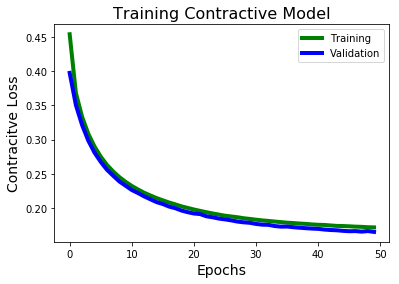

In [26]:
plt.plot(history_contractive.history['loss'], lw=4, label="Training", c='green')
plt.plot(history_contractive.history['val_loss'], lw=4, label="Validation", c='blue')
plt.xlabel('Epochs', size=14)
plt.ylabel('Contracitve Loss', size=14)
plt.title('Training Contractive Model', size=16)
plt.legend()
plt.show()

## Eigen Vector Centrality - One

In [4]:
matrix_width = 5
vector_length = int((nodes ** 2 - nodes)/2)
time_step = 800
X_train_eigen_1, y_train_eigen_1 = training_eigen_1(df, time_step, matrix_width, 50000)
x_validate_eigen_1, y_validate_eigen_1 = training_eigen_1(df, time_step, matrix_width, 1500)

 45%|████▍     | 22287/50000 [2:19:05<2:52:56,  2.67it/s]

KeyboardInterrupt: 

In [63]:
X_train_eigen_1.shape

NameError: name 'X_train_eigen_1' is not defined